# Predicting Movie Success Using Machine Learning
#### By Zachary Szentimrey, Adesh Kadambi and Rylee Thompson

## Introduction

The purpose of this notebook is to create a model or models which can predict how successful a movie will be. We are defining success as how much money a movie makes and how many Academy Award wins/ nominations they have. The more money and awards, the greater amount of success. The models will be developped using a regression model to determine the amount of money made and a classification model for number of Oscar wins. The accuracy of these models will be found which wll be used to validate the model(s).

## Methodology and Results

In order to predict movie success, data needs to be collected in order to both create the model and test the model. IMDb website will be used to scrape movie data information pertaining to genre, actors involved and parental rating just to name a few. Additionally, a .csv database file will be used to collect Oscar wins/nomination information for actors and directors as this information is not easily accessible on IMDb. Scraping will be performed using Beautiful Soup and skikit-learn will be used to build the models.

The below libraries are used to perform data collection, database manipulation and to build the models. As well, random seeds are selected to ensure approximately the same outcome always occurs (predictable results).

In [1]:
from requests import get
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from numpy import array
from numpy import argmax
from operator import add
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import random
import numpy.random
numpy.random.seed(5)
random.seed(5)

### Working with Database 

Following code access the .csv database file attached and preconditions the database in order to gather the data into dictionaries. Of all the Oscar categories that exist, the actors/actresses and director awards are considered the most important as this information is easy to scrape on IMDb. The dictionaries are based on the following categories.

- actorAwards = awards that can be recieved directly by an actor/actress
- directorAwards = awards that can be received directly by a director
- movieAwards = awards that directors and actors can directly influence

In [2]:
actorAwards = ['Actor', 'Actor in a Supporting Role', 'Actress', 'Actress in a Supporting Role', 'Actor in a Leading Role', 
               'Actress in a Leading Role']

directorAwards = ['Directing'] #For this dataset that name of the director is in the 'Film' category

movieAwards = ['Best Motion Picture', 'Outstanding Motion Picture', 'Documentary', 'Documentary (Feature)', 
               'Documentary (Short Subject)', 'Short Subject (Cartoon)', 'Short Subject (One Reel)',
               'Short Film (Animated)', 'Short Film (Live Action)', 'Best Picture', 'Animated Feature Film'] #Movie name is in the 'name' category

#Awards like writing, screenplay, production, etc are saved under other awards as the actor and director do not
#influence them as directly (or at all) as the ones above

OscarRead = pd.read_csv('OscarDatabase.csv') #read the database
yearCSV = OscarRead["Year"] #The year the movie was released
awardCSV = OscarRead["Award"] #The name of the award received/nominated for
winnerCSV = OscarRead["Winner"] #If the entry won or not

resultsCSV = winnerCSV.copy() #Create a copy to edit
resultsCSV[resultsCSV != 1] = 0 #Original CSV has a '1' for winner, and NaN for a nomination - convert NaN to '0'

nameCSV = OscarRead["Name"] 
filmCSV = OscarRead["Film"]

win = 1
nomination = 0

def getDict(awards, result = win, name = nameCSV, film = filmCSV, starAwards = True, otherAwards = False):
    
    Dict = {}
    for i in range(len(yearCSV)):
        if otherAwards == False and awardCSV[i] not in awards or resultsCSV[i] != result:
            continue
        elif otherAwards == True and awardCSV[i] in awards or resultsCSV[i] != result:
            continue
        if starAwards == False:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]] += 1 #If the movie wins multiple awards in a year
                except:
                    Dict[yearCSV[i] + 1][name[i]] = 1 #Set the value for movie to one if the year is already in the dictionary
            except:
                Dict[yearCSV[i] + 1] = {} #if year is not in dictionary yet then create it
                Dict[yearCSV[i] + 1][name[i]] = 1 #set the value to one
                #Above code uses year + 1 for the key as the original database has the release year of the movie stored, 
                #not the year of the oscars
        else:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]][1] += 1
                except:
                    Dict[yearCSV[i] + 1][name[i]] = film[i], 1
            except:
                Dict[yearCSV[i] + 1] = {}
                Dict[yearCSV[i] + 1][name[i]] = film[i], 1            
    return Dict

Creates a dictionary which contains Oscar wins and nominations for every Oscar that has ever been awarded (1935-2018).If a movie/actor/director wins an award, it is only saved as a winner and will not have an entry for the nomination it received for that award. Displayed from this data is the 1950 oscar winners and oscar nominees. This is to see if the databases are accurate. Additionally, the 2018 oscar winners for awards other than acting, directing and best film are listed.

In [3]:
OscarActorWinners = getDict(actorAwards)
OscarActorNoms = getDict(actorAwards, nomination)
OscarDirWinners = getDict(directorAwards, name = filmCSV, film = nameCSV)
OscarDirNoms = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV)
movieWinners = getDict(movieAwards, starAwards = False)
movieNoms = getDict(movieAwards, nomination, starAwards = False)
otherAwardWinners = getDict(actorAwards + movieAwards + directorAwards, starAwards = False, otherAwards = True)
otherAwardNoms = getDict(actorAwards + movieAwards + directorAwards, nomination, starAwards = False, otherAwards = True)

print("1950 oscar winners (acting) are:", OscarActorWinners[1951])
print("1950 oscar nominees (acting) are:", OscarActorNoms[1950])


otherAwardWinners[2018]

1950 oscar winners (acting) are: {'José Ferrer': ('Cyrano de Bergerac', 1), 'George Sanders': ('All about Eve', 1), 'Judy Holliday': ('Born Yesterday', 1), 'Josephine Hull': ('Harvey', 1)}
1950 oscar nominees (acting) are: {'Kirk Douglas': ('Champion', 1), 'Gregory Peck': ("Twelve O'Clock High", 1), 'Richard Todd': ('The Hasty Heart', 1), 'John Wayne': ('Sands of Iwo Jima', 1), 'John Ireland': ("All the King's Men", 1), 'Arthur Kennedy': ('Champion', 1), 'Ralph Richardson': ('The Heiress', 1), 'James Whitmore': ('Battleground', 1), 'Jeanne Crain': ('Pinky', 1), 'Susan Hayward': ('My Foolish Heart', 1), 'Deborah Kerr': ('Edward, My Son', 1), 'Loretta Young': ('Come to the Stable', 1), 'Ethel Barrymore': ('Pinky', 1), 'Celeste Holm': ('Come to the Stable', 1), 'Elsa Lanchester': ('Come to the Stable', 1), 'Ethel Waters': ('Pinky', 1)}


{'Coco': 1,
 'The Shape of Water': 2,
 'Blade Runner 2049': 2,
 'Get Out': 1,
 'Call Me by Your Name': 1,
 'The Silent Child': 1,
 'Dunkirk': 3,
 'Dear Basketball': 1,
 'A Fantastic Woman': 1,
 'Phantom Thread': 1,
 'Darkest Hour': 1}

As seen below, Gary Oldman won an oscar for his role in Darkest Hour. This ensures the dictionary work and shows the correct results when accessing a key.

In [4]:
OscarActorWinners[2018]['Gary Oldman'][0]

'Darkest Hour'

These are the same as the dictionaries above except that for the starAwards = False tag. Using this simply returns a dictionary of the form Dict[year][actor] = oscars won in year, instead of Dict[year][actor] = movie. Simply makes it easier to deal with just the numbers.

In [5]:
OscarActorWinnersDupe = getDict(actorAwards, starAwards = False)
OscarActorNomsDupe = getDict(actorAwards, nomination, starAwards = False)
OscarDirWinnersDupe = getDict(directorAwards, name = filmCSV, film = nameCSV, starAwards = False)
OscarDirNomsDupe = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV, starAwards = False)

The code below takes in the previous dictionaries and makes a nested dictionary where a running total of Oscar wins for an actor/director is recorded. This means if an actor won an award in the year 1976, the award does not count for movies in which that actor was previously in. The nested dictionary is validated by observing Anthony Quinn's oscar wins. It can be seen he had 1 Oscar in 1953 but by 1957, he had 2 OScars.

In [6]:
startYear = 1934 + 1
endYear = 2018
def getRunningTotal(Dict):

    totalDict = {}
    totalDict[startYear] = Dict[startYear]
            
    for year in range(startYear + 1, endYear + 1):
        totalDict[year] = {}
        totalDict[year].update(totalDict[year - 1]) #update dictionary with previous year to keep a running total each year
    
        for key, value in Dict[year].items():
            try:
                totalDict[year][key] += 1 #if the actor is already present increment by 1
            except:
                totalDict[year][key] = 1 #set it to 1 if not already present
    return totalDict

OscarActorWinnersTot = getRunningTotal(OscarActorWinnersDupe)
OscarActorNomsTot = getRunningTotal(OscarActorNomsDupe)
OscarDirWinnersTot = getRunningTotal(OscarDirWinnersDupe)
OscarDirNomsTot = getRunningTotal(OscarDirNomsDupe)

print(OscarActorWinnersTot[1953]['Anthony Quinn'])
print(OscarActorWinnersTot[1957]['Anthony Quinn']) #Anthony won an Oscar in 1953 and 1957
#OscarActorWinnersTot[2018]

1
2


Just for fun, a list of directors who won more than 1 award and actors who won more than 2 awards are shown below.

In [7]:
for key, value in OscarDirWinnersTot[2018].items(): #Directors that won multiple awards (just for fun lol)
    if value >= 2:
        print(key)
        print(value)
        
for key, value in OscarActorWinnersTot[2018].items(): #Actors that won multiple awards (just for fun lol)
    if value >= 3:
        print(key)
        print(value)

Frank Capra
3
John Ford
4
Leo McCarey
2
William Wyler
3
Billy Wilder
2
Elia Kazan
2
Joseph L. Mankiewicz
2
George Stevens
2
Fred Zinnemann
2
David Lean
2
Milos Forman
2
Oliver Stone
2
Clint Eastwood
2
Steven Spielberg
2
Ang Lee
2
Alejandro G. Iñárritu
2
Walter Brennan
3
Ingrid Bergman
3
Katharine Hepburn
3
Jack Nicholson
3
Meryl Streep
3


### Web Scraping

In order to get all of the features required to create the prediction model, data from movies needs to be scraped. The website that contains a lot of information on movies is IMDb. This website contains information on thousands of movies including the features below.

- name of the movie
- year the movie was made
- genre of the movie
- movie runtime
- amount of money the movie made
- Metascore
- IMDb rating
- parental/audience rating
- actors and director in the movie
- number of user votes

Below, multiple IMDb URL's are accessed in order to collect information on many movies. Each webpage contain 50 movies so this for loop creates a list of URL's where 50 movies exists on each page. 

In [8]:
urlArray = []

numMovies = 10000 #numMovies must be less than 300,908, numMovies % 50 must be 0

for i in range(1, numMovies - 48, 50): #create an array of urls to iterate through
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&sort=boxoffice_gross_us,desc&start=' #gross
                    + str(i) + '&ref_=adv_nxt')
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&start=' + str(i) + '&ref_=adv_nxt') #popularity
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1935-01-01,2017-12-31&sort=num_votes,desc&start=' + str(i) + '&ref_=adv_nxt') #numVotes

The function `cleandata()` is used later after collecting the information. This function turns a string of numbers into numeric values or it removes unncessary spacing. This is for the movie year, genre, runtme, box office gross and user votes.

In [9]:
def cleanData(year_, genre, runtime, box_office, votes):
    year1 = ''.join(c for c in year_ if c.isdigit()) #remove non-numeric characters from year
    
    genre1 = ''.join(c for c in genre if (c != '\n')) #original data has '\n' scattered around... remove those
    
    runtime1 = ''.join(c for c in runtime if c.isdigit()) #remove non-numeric characters from runtime
    
    box = ''.join(c for c in box_office if (c.isdigit() or c == '.')) #remove non-numeric characters, but keep the decimal
    box = round(float(box) * (10**6)) #original is in millions
    
    votes1 = ''.join(c for c in votes if c.isdigit()) #remove non-numeric characters from votes
    
    
    return int(year1), genre1, int(runtime1), box, int(votes1)

The function `normalize()` is used to normalize the runtime and movie gross data to be used for the machine learning model. This function will work but the `normalize()` function fom sci-kit learn is used instead later after collecting the data

In [10]:
def normalize(runtime, gross):
    nor_runtime = np.divide(runtime,max(runtime))
    nor_gross = np.divide(gross,max(gross))
    return nor_runtime, nor_gross

The `CPIdict` is a dictionary which contains multiplication values (imported from .csv file) to adjust the box office gross values into today's dollar value.

In [11]:
CPIdict = {}
CPIread = pd.read_csv('CPI.csv') #CPI.csv contains the multiplication factor to get from a given year to 2019 to adjust
                                 #for inflation
for i in range(len(CPIread["Growth"] + 1)):
     CPIdict[CPIread["Year"][i]] = CPIread["To 2019"][i]
print("Movies released in 1990 have a multiplier of", CPIdict[1990], "to their gross to adjust for inflation")

Movies released in 1990 have a multiplier of 1.9345070969999998 to their gross to adjust for inflation


The function `inflationAdjust()` multiplies the gross value by the multiplication factor for the year it was released.

In [12]:
def inflationAdjust(year, box_office):
    return int(round(box_office * CPIdict[year])) 

The function `getOscarNum` is used to evaulate each movie thats is scraped to add the number of Oscar win and nominations to a movie based on the actors and director involved. This function uses the function `checkDict()` in order to accomplish this task. The function returns the nominations and wins in the following order.
1. prevStarWins
2. prevStarNoms
3. starWins
4. starNoms
5. movieWinsVal
6. movieNomsVal
7. otherWins
8. otherNoms

In [13]:
def getOscarNum(actor1, actor2, actor3, actor4, actor5, movieName, releaseYear):
    stars = []
    stars.extend([actor1, actor2, actor3, actor4, actor5])
    prevStarWins = prevStarNoms = starWins = starNoms = movieWinsVal = movieNomsVal = otherWins = otherNoms = 0
    oscarYear = releaseYear + 1
    for star in stars:
        if star != '': #Checks how many oscar nominations and wins the directors and actors have prior to this movie
            prevStarWins += checkDict(star, OscarDirWinnersTot, releaseYear) #
            prevStarWins += checkDict(star, OscarActorWinnersTot, releaseYear)
            prevStarNoms += checkDict(star, OscarDirNomsTot, releaseYear)
            prevStarNoms += checkDict(star, OscarActorNomsTot, releaseYear)
            starWins += checkDict(star, OscarDirWinners, oscarYear, movie = movieName)
            starWins += checkDict(star, OscarActorWinners, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarDirNoms, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarActorNoms, oscarYear, movie = movieName)
    #Checks num of nominations/wins this movie received
    movieWinsVal += checkDict(movieName, movieWinners, oscarYear)
    movieNomsVal += checkDict(movieName, movieNoms, oscarYear)
    otherWins += checkDict(movieName, otherAwardWinners, oscarYear)
    otherNoms += checkDict(movieName, otherAwardNoms, oscarYear)
    return prevStarWins, prevStarNoms, starWins, starNoms, movieWinsVal, movieNomsVal, otherWins, otherNoms
        
def checkDict(name, Dict, year, movie = None):
    num = 0
    movieName = []
    if movie == None:
        try:
            num += Dict[year][name]       
        except:
            pass
    else:
        try:
            movieName = Dict[year][name][0]
            if movieName == movie:
                num += 1
        except:
            pass
    return num

Below we check that the function `getOscarNum()` works using Gary Oldman. Gary won an award for his role in Darkest Hour so starWins is 1 (third number in the list).

In [14]:
x = getOscarNum('Gary Oldman', '', '', '', '', 'Darkest Hour', 2017)
x 

(0, 1, 1, 0, 0, 1, 1, 3)

Gary didn't win an award for this movie so starWins is 0 (third number in the list) which is seen below.

In [15]:
x = getOscarNum('Gary Oldman', '', '', '', '', 'not a real movie', 2017)
x 

(0, 1, 0, 0, 0, 0, 0, 0)

The backbone of the web scraping is performed in the next block of code. What this code does is it cycles through each URL that contains 50 movies and extracts the important information feature mentioned earlier. After collecting each feature, the data is cleaned using previously defined functions and appended to a list. As each movie's information is collected, if anything is missing or the same movie appears multiple times, that movie is dropped from the list and the next movie is tried. Each movie that conatins missing or duplicated data is returned to show that the web-scraping is working.

Finally, once all the movies are scraped, the appended list is unzipped to create lists of all the features and information collected.

**This part of the notebook can take up to 30 minutes to perform.**

In [16]:
names = []
year = []
genres = []
runtimes = []
metascores = []
imdbRatings = []
audienceRating = []
movieGross = []
directors =[]
movieGrossInflation = []
Star1 = []
Star2 = []
Star3 = []
Star4 = []
Star5 = []
res = []
missingData = 0
checkname = []

for url in urlArray:
    response = get(url)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    movie_cont = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
    
    for movie in movie_cont:
        try:
            name = movie.h3.a.text
            if name in names:
                raise error
        except:
            continue
        try:
            if name in checkname:
                raise ValueError
            year_ = movie.h3.find('span', class_ = 'lister-item-year text-muted unbold').text
            genre = movie.p.find('span', class_ = 'genre').text
            runtime = movie.p.find('span', class_ = 'runtime').text
            viewer_rating = movie.p.span.text
            if viewer_rating == runtime:
                raise Error
            m_score = movie.find('span', class_ = 'metascore').text
            imdb_rating = float(movie.strong.text)
            box_office = movie.find_all('span', attrs = {'name': 'nv'})[1].text
            votes = movie.find_all('span', attrs = {'name': 'nv'})[0].text
            people = movie.find_all('p', class_ = '')[0]
            people = people.find_all('a')
            director = people[0].text
            actor1 = people[1].text
            
            #This try/except block is just in case lesser known movies are missing actors (might happen when
            #numMovies is set to like 10000, and I don't think it's a big deal as long as we have one actor + director)
            try:
                actor2 = people[2].text
            except:
                actor2 = ''
            try:
                actor3 = people[3].text
            except:
                actor3 = ''
            try:
                actor4 = people[4].text
            except:
                actor4 = ''
            try:
                actor5 = people[5].text
            except:
                actor5 =''
            
            checkname.append(name)
            year_, genre, runtime, box_office, votes = cleanData(year_, genre, runtime, box_office, votes) #clean up data
            
            box_office_inflation = inflationAdjust(year_, box_office) #adjust for inflation
            
            numStarWins, numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms = getOscarNum(actor1, actor2, actor3, actor4, actor5, name, year_)
                
            res.append((name, year_, genre, runtime, director, actor1, actor2, actor3, actor4, actor5,
                        viewer_rating, m_score, imdb_rating, votes, box_office, box_office_inflation, numStarWins, 
                        numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms))
        except:
            print("Missing/Duplicate data for:", name)
            missingData += 1
            
(names, year, genres, runtimes, directors, Star1, Star2, Star3, Star4, Star5, audienceRatings, metascores, 
imdbRatings, numVotes, movieGross, movieGrossInflation, starWinsList, starNomsList, starWon, starNom, movieWinsList, movieNomsList, 
otherWinsList, otherNomsList) = zip(*res)

Missing/Duplicate data for: Unicorn Store
Missing/Duplicate data for: Beauty and the Beast
Missing/Duplicate data for: Guardians of the Galaxy
Missing/Duplicate data for: The Dark Knight
Missing/Duplicate data for: Love
Missing/Duplicate data for: Spider-Man: Homecoming
Missing/Duplicate data for: Guardians of the Galaxy Vol. 2
Missing/Duplicate data for: The Avengers
Missing/Duplicate data for: Avengers: Age of Ultron
Missing/Duplicate data for: Bonnie and Clyde
Missing/Duplicate data for: Wonder Woman
Missing/Duplicate data for: Captain America: Civil War
Missing/Duplicate data for: The Shawshank Redemption
Missing/Duplicate data for: The Dark Knight
Missing/Duplicate data for: Inception
Missing/Duplicate data for: Pulp Fiction
Missing/Duplicate data for: The Lord of the Rings: The Fellowship of the Ring
Missing/Duplicate data for: The Matrix
Missing/Duplicate data for: The Lord of the Rings: The Return of the King
Missing/Duplicate data for: The Godfather
Missing/Duplicate data for:

Missing/Duplicate data for: Apocalypse Now
Missing/Duplicate data for: Kingsman: The Secret Service
Missing/Duplicate data for: Ted
Missing/Duplicate data for: Jurassic World
Missing/Duplicate data for: Thor: The Dark World
Missing/Duplicate data for: Inside Out
Missing/Duplicate data for: Suicide Squad
Missing/Duplicate data for: The Amazing Spider-Man
Missing/Duplicate data for: Frozen
Missing/Duplicate data for: Jaws
Missing/Duplicate data for: Doctor Strange
Missing/Duplicate data for: Spider-Man 2
Missing/Duplicate data for: Independence Day
Missing/Duplicate data for: Harry Potter and the Chamber of Secrets
Missing/Duplicate data for: Ant-Man
Missing/Duplicate data for: Harry Potter and the Prisoner of Azkaban
Missing/Duplicate data for: Harry Potter and the Goblet of Fire
Missing/Duplicate data for: Wonder Woman
Missing/Duplicate data for: X2
Missing/Duplicate data for: The Matrix Reloaded
Missing/Duplicate data for: Men in Black
Missing/Duplicate data for: Rogue One
Missing/Dup

Missing/Duplicate data for: The Sound of Music
Missing/Duplicate data for: Star Trek
Missing/Duplicate data for: Zootopia
Missing/Duplicate data for: Kung Fu Panda
Missing/Duplicate data for: The Hunger Games: Mockingjay - Part 1
Missing/Duplicate data for: Quantum of Solace
Missing/Duplicate data for: Blade Runner 2049
Missing/Duplicate data for: The Da Vinci Code
Missing/Duplicate data for: We're the Millers
Missing/Duplicate data for: Armageddon
Missing/Duplicate data for: Big Hero 6
Missing/Duplicate data for: The Mummy
Missing/Duplicate data for: Dead Poets Society
Missing/Duplicate data for: Transformers: Dark of the Moon
Missing/Duplicate data for: King Kong
Missing/Duplicate data for: Transformers: Revenge of the Fallen
Missing/Duplicate data for: Tangled
Missing/Duplicate data for: The 40 Year Old Virgin
Missing/Duplicate data for: Hacksaw Ridge
Missing/Duplicate data for: Fantastic Beasts and Where to Find Them
Missing/Duplicate data for: Mission: Impossible
Missing/Duplicate

Missing/Duplicate data for: The Curious Case of Benjamin Button
Missing/Duplicate data for: Dumb and Dumber
Missing/Duplicate data for: Super 8
Missing/Duplicate data for: Lucy
Missing/Duplicate data for: Prometheus
Missing/Duplicate data for: The Truman Show
Missing/Duplicate data for: Ocean's Twelve
Missing/Duplicate data for: Terminator Salvation
Missing/Duplicate data for: Life of Pi
Missing/Duplicate data for: The Fault in Our Stars
Missing/Duplicate data for: The Devil Wears Prada
Missing/Duplicate data for: The Bourne Identity
Missing/Duplicate data for: Superbad
Missing/Duplicate data for: Speed
Missing/Duplicate data for: 50 First Dates
Missing/Duplicate data for: Inglourious Basterds
Missing/Duplicate data for: A Few Good Men
Missing/Duplicate data for: A Star Is Born
Missing/Duplicate data for: Aladdin
Missing/Duplicate data for: Fargo
Missing/Duplicate data for: Crash
Missing/Duplicate data for: Unforgiven
Missing/Duplicate data for: Prometheus
Missing/Duplicate data for: S

Missing/Duplicate data for: Batman & Robin
Missing/Duplicate data for: Captain Phillips
Missing/Duplicate data for: Black Swan
Missing/Duplicate data for: GoldenEye
Missing/Duplicate data for: 300: Rise of an Empire
Missing/Duplicate data for: The Italian Job
Missing/Duplicate data for: Every Which Way but Loose
Missing/Duplicate data for: Robin Hood
Missing/Duplicate data for: Interview with the Vampire: The Vampire Chronicles
Missing/Duplicate data for: The Graduate
Missing/Duplicate data for: Pitch Perfect 3
Missing/Duplicate data for: Dick Tracy
Missing/Duplicate data for: Independence Day: Resurgence
Missing/Duplicate data for: The Expendables
Missing/Duplicate data for: Scream
Missing/Duplicate data for: Just Go with It
Missing/Duplicate data for: Murder on the Orient Express
Missing/Duplicate data for: The Aviator
Missing/Duplicate data for: American Pie
Missing/Duplicate data for: The Girl with the Dragon Tattoo
Missing/Duplicate data for: The Conjuring 2
Missing/Duplicate data

Missing/Duplicate data for: Scary Movie
Missing/Duplicate data for: A Few Good Men
Missing/Duplicate data for: Lawless
Missing/Duplicate data for: The Bucket List
Missing/Duplicate data for: Enemy of the State
Missing/Duplicate data for: Spy
Missing/Duplicate data for: Dodgeball: A True Underdog Story
Missing/Duplicate data for: Now You See Me 2
Missing/Duplicate data for: Hook
Missing/Duplicate data for: Manchester by the Sea
Missing/Duplicate data for: Walk the Line
Missing/Duplicate data for: Finding Dory
Missing/Duplicate data for: The Little Mermaid
Missing/Duplicate data for: The Twilight Saga: Eclipse
Missing/Duplicate data for: Grown Ups
Missing/Duplicate data for: Grease
Missing/Duplicate data for: Identity
Missing/Duplicate data for: Ghost Rider
Missing/Duplicate data for: Star Trek Beyond
Missing/Duplicate data for: Paranormal Activity
Missing/Duplicate data for: The Twilight Saga: Breaking Dawn - Part 1
Missing/Duplicate data for: The Beach
Missing/Duplicate data for: Megam

Missing/Duplicate data for: The School of Rock
Missing/Duplicate data for: 21
Missing/Duplicate data for: The Notebook
Missing/Duplicate data for: Hush
Missing/Duplicate data for: Moulin Rouge!
Missing/Duplicate data for: Men in Black II
Missing/Duplicate data for: 10 Cloverfield Lane
Missing/Duplicate data for: The Last Airbender
Missing/Duplicate data for: Eastern Promises
Missing/Duplicate data for: Raging Bull
Missing/Duplicate data for: Erin Brockovich
Missing/Duplicate data for: Dangal
Missing/Duplicate data for: Exposed
Missing/Duplicate data for: The World Is Not Enough
Missing/Duplicate data for: I, Robot
Missing/Duplicate data for: Kick-Ass 2
Missing/Duplicate data for: The Mist
Missing/Duplicate data for: Little Miss Sunshine
Missing/Duplicate data for: The Lost World: Jurassic Park
Missing/Duplicate data for: Wedding Crashers
Missing/Duplicate data for: A Walk to Remember
Missing/Duplicate data for: Burn Out
Missing/Duplicate data for: American Graffiti
Missing/Duplicate da

Missing/Duplicate data for: The Boy in the Striped Pyjamas
Missing/Duplicate data for: Hidden Figures
Missing/Duplicate data for: The Evil Dead
Missing/Duplicate data for: Rosemary's Baby
Missing/Duplicate data for: Cruel Intentions
Missing/Duplicate data for: Miss Congeniality
Missing/Duplicate data for: Tomorrow Never Dies
Missing/Duplicate data for: Rocky IV
Missing/Duplicate data for: Who Framed Roger Rabbit
Missing/Duplicate data for: The Magnificent Seven
Missing/Duplicate data for: Battle Los Angeles
Missing/Duplicate data for: Love & Other Drugs
Missing/Duplicate data for: Eagle Eye
Missing/Duplicate data for: Ghostbusters II
Missing/Duplicate data for: Air Force One
Missing/Duplicate data for: The Blues Brothers
Missing/Duplicate data for: Close Encounters of the Third Kind
Missing/Duplicate data for: King Arthur: Legend of the Sword
Missing/Duplicate data for: 17 Again
Missing/Duplicate data for: Shrek Forever After
Missing/Duplicate data for: Waterworld
Missing/Duplicate dat

Missing/Duplicate data for: Swordfish
Missing/Duplicate data for: Road Trip
Missing/Duplicate data for: Bring It On
Missing/Duplicate data for: The Tourist
Missing/Duplicate data for: This Is 40
Missing/Duplicate data for: Heat
Missing/Duplicate data for: Holes
Missing/Duplicate data for: Insomnia
Missing/Duplicate data for: A Good Day to Die Hard
Missing/Duplicate data for: Role Models
Missing/Duplicate data for: Lights Out
Missing/Duplicate data for: Hacksaw Ridge
Missing/Duplicate data for: Coal Miner's Daughter
Missing/Duplicate data for: Waiting to Exhale
Missing/Duplicate data for: The Secret of My Success
Missing/Duplicate data for: 102 Dalmatians
Missing/Duplicate data for: The Godfather: Part III
Missing/Duplicate data for: The Ring
Missing/Duplicate data for: Border Incident
Missing/Duplicate data for: The Ugly Truth
Missing/Duplicate data for: Sinister
Missing/Duplicate data for: Lolita
Missing/Duplicate data for: Journey 2: The Mysterious Island
Missing/Duplicate data for: 

Missing/Duplicate data for: Friends with Benefits
Missing/Duplicate data for: Cocoon
Missing/Duplicate data for: Star Trek III: The Search for Spock
Missing/Duplicate data for: Hot Tub Time Machine
Missing/Duplicate data for: Gattaca
Missing/Duplicate data for: We Were Soldiers
Missing/Duplicate data for: Man on Fire
Missing/Duplicate data for: Salt
Missing/Duplicate data for: The Game
Missing/Duplicate data for: The Hunger Games: Mockingjay - Part 1
Missing/Duplicate data for: Toy Story 2
Missing/Duplicate data for: The Island
Missing/Duplicate data for: A Series of Unfortunate Events
Missing/Duplicate data for: April Fool's Day
Missing/Duplicate data for: Captain Phillips
Missing/Duplicate data for: Striptease
Missing/Duplicate data for: Star Trek II: The Wrath of Khan
Missing/Duplicate data for: The Hills Have Eyes
Missing/Duplicate data for: Rocky Balboa
Missing/Duplicate data for: San Andreas
Missing/Duplicate data for: The Adventures of Buckaroo Banzai Across the 8th Dimension
Mi

Missing/Duplicate data for: We Bought a Zoo
Missing/Duplicate data for: Double Indemnity
Missing/Duplicate data for: Four Weddings and a Funeral
Missing/Duplicate data for: Spring Breakers
Missing/Duplicate data for: The Purge: Anarchy
Missing/Duplicate data for: Ladri di biciclette
Missing/Duplicate data for: Fun with Dick and Jane
Missing/Duplicate data for: Four Brothers
Missing/Duplicate data for: Carrie
Missing/Duplicate data for: Tower Heist
Missing/Duplicate data for: Kindergarten Cop
Missing/Duplicate data for: The Wedding Singer
Missing/Duplicate data for: Payback
Missing/Duplicate data for: Allied
Missing/Duplicate data for: Monster
Missing/Duplicate data for: Magic Mike
Missing/Duplicate data for: London Has Fallen
Missing/Duplicate data for: La vie d'Adèle
Missing/Duplicate data for: Into the Woods
Missing/Duplicate data for: What We Do in the Shadows
Missing/Duplicate data for: I Know What You Did Last Summer
Missing/Duplicate data for: Trading Places
Missing/Duplicate dat

Missing/Duplicate data for: Joy
Missing/Duplicate data for: The Monuments Men
Missing/Duplicate data for: Eragon
Missing/Duplicate data for: About Schmidt
Missing/Duplicate data for: White Chicks
Missing/Duplicate data for: Roman Holiday
Missing/Duplicate data for: Bambi
Missing/Duplicate data for: She's Out of My League
Missing/Duplicate data for: Transformers: The Last Knight
Missing/Duplicate data for: My Best Friend's Wedding
Missing/Duplicate data for: The Break-Up
Missing/Duplicate data for: Brooklyn
Missing/Duplicate data for: Good Morning, Vietnam
Missing/Duplicate data for: Kung fu
Missing/Duplicate data for: The Princess Diaries
Missing/Duplicate data for: Alice in Wonderland
Missing/Duplicate data for: Blazing Saddles
Missing/Duplicate data for: Pinocchio
Missing/Duplicate data for: The Curse of the Were-Rabbit
Missing/Duplicate data for: Deep Blue Sea
Missing/Duplicate data for: Identity Thief
Missing/Duplicate data for: John Q
Missing/Duplicate data for: The Addams Family


Missing/Duplicate data for: Star Trek: First Contact
Missing/Duplicate data for: Wild
Missing/Duplicate data for: The Disaster Artist
Missing/Duplicate data for: This Is England
Missing/Duplicate data for: Planes, Trains & Automobiles
Missing/Duplicate data for: The Phantom of the Opera
Missing/Duplicate data for: Bronson
Missing/Duplicate data for: Wonder
Missing/Duplicate data for: Wild Hogs
Missing/Duplicate data for: Funny People
Missing/Duplicate data for: Babe
Missing/Duplicate data for: Rambo III
Missing/Duplicate data for: The Princess and the Frog
Missing/Duplicate data for: Lady and the Tramp
Missing/Duplicate data for: The Prince of Egypt
Missing/Duplicate data for: The Bodyguard
Missing/Duplicate data for: The Parent Trap
Missing/Duplicate data for: In the Heart of the Sea
Missing/Duplicate data for: House of Wax
Missing/Duplicate data for: Dumbo
Missing/Duplicate data for: Valentine's Day
Missing/Duplicate data for: Y tu mamá también
Missing/Duplicate data for: City of Ang

Missing/Duplicate data for: Peter Pan
Missing/Duplicate data for: The Huntsman: Winter's War
Missing/Duplicate data for: The Game
Missing/Duplicate data for: The House Bunny
Missing/Duplicate data for: The Preacher's Wife
Missing/Duplicate data for: Sinister
Missing/Duplicate data for: Kick-Ass
Missing/Duplicate data for: Kubo and the Two Strings
Missing/Duplicate data for: Secret Window
Missing/Duplicate data for: The Jungle Book 2
Missing/Duplicate data for: Alien: Resurrection
Missing/Duplicate data for: Manchester by the Sea
Missing/Duplicate data for: The Kingdom
Missing/Duplicate data for: Look Who's Talking Too
Missing/Duplicate data for: Poltergeist
Missing/Duplicate data for: Munich
Missing/Duplicate data for: Kingdom of Heaven
Missing/Duplicate data for: Precious
Missing/Duplicate data for: Jupiter Ascending
Missing/Duplicate data for: Savages
Missing/Duplicate data for: Warcraft
Missing/Duplicate data for: The Perfect Storm
Missing/Duplicate data for: The Elephant Man
Missin

Missing/Duplicate data for: You Don't Mess with the Zohan
Missing/Duplicate data for: Casper
Missing/Duplicate data for: The Green Hornet
Missing/Duplicate data for: A History of Violence
Missing/Duplicate data for: 30 Days of Night
Missing/Duplicate data for: Mona Lisa Smile
Missing/Duplicate data for: Tra(sgre)dire
Missing/Duplicate data for: Blade: Trinity
Missing/Duplicate data for: Teenage Mutant Ninja Turtles
Missing/Duplicate data for: Demolition Man
Missing/Duplicate data for: Låt den rätte komma in
Missing/Duplicate data for: The Lucky One
Missing/Duplicate data for: Chronicle
Missing/Duplicate data for: Annie Hall
Missing/Duplicate data for: The Day the Earth Stood Still
Missing/Duplicate data for: Hocus Pocus
Missing/Duplicate data for: The Game Plan
Missing/Duplicate data for: Cold Skin
Missing/Duplicate data for: Idi i smotri
Missing/Duplicate data for: The Boss
Missing/Duplicate data for: Phoenix
Missing/Duplicate data for: AVPR: Aliens vs Predator - Requiem
Missing/Dupli

Missing/Duplicate data for: Why Him?
Missing/Duplicate data for: U.S. Marshals
Missing/Duplicate data for: Friday the 13th
Missing/Duplicate data for: Driving Miss Daisy
Missing/Duplicate data for: The Final Destination
Missing/Duplicate data for: Tango & Cash
Missing/Duplicate data for: Coherence
Missing/Duplicate data for: The Cider House Rules
Missing/Duplicate data for: Annabelle: Creation
Missing/Duplicate data for: Easy Rider
Missing/Duplicate data for: You Only Live Twice
Missing/Duplicate data for: Patton
Missing/Duplicate data for: Ali
Missing/Duplicate data for: Splice
Missing/Duplicate data for: The Killing of a Sacred Deer
Missing/Duplicate data for: Live and Let Die
Missing/Duplicate data for: Scooby-Doo
Missing/Duplicate data for: Conspiracy Theory
Missing/Duplicate data for: West Side Story
Missing/Duplicate data for: Iron Sky
Missing/Duplicate data for: The Conversation
Missing/Duplicate data for: Vacation
Missing/Duplicate data for: Ghost Ship
Missing/Duplicate data fo

Missing/Duplicate data for: If I Stay
Missing/Duplicate data for: The Butler
Missing/Duplicate data for: Gremlins 2: The New Batch
Missing/Duplicate data for: Edge of Darkness
Missing/Duplicate data for: Dreamcatcher
Missing/Duplicate data for: Anna Karenina
Missing/Duplicate data for: Phantom Thread
Missing/Duplicate data for: Silence
Missing/Duplicate data for: While You Were Sleeping
Missing/Duplicate data for: A League of Their Own
Missing/Duplicate data for: Mean Streets
Missing/Duplicate data for: Cool Runnings
Missing/Duplicate data for: Waiting...
Missing/Duplicate data for: Gremlins 2: The New Batch
Missing/Duplicate data for: Paddington
Missing/Duplicate data for: Smultronstället
Missing/Duplicate data for: Jingle All the Way
Missing/Duplicate data for: The Losers
Missing/Duplicate data for: For Your Eyes Only
Missing/Duplicate data for: Dead Man
Missing/Duplicate data for: What Happened to Monday
Missing/Duplicate data for: Saw 3D
Missing/Duplicate data for: WarGames
Missing

Missing/Duplicate data for: Malèna
Missing/Duplicate data for: The Purge: Election Year
Missing/Duplicate data for: My Fair Lady
Missing/Duplicate data for: Cashback
Missing/Duplicate data for: Crazy Heart
Missing/Duplicate data for: Mirror Mirror
Missing/Duplicate data for: Ghost Dog: The Way of the Samurai
Missing/Duplicate data for: Meet the Robinsons
Missing/Duplicate data for: Cop Land
Missing/Duplicate data for: The Last House on the Left
Missing/Duplicate data for: You're Next
Missing/Duplicate data for: Finding Forrester
Missing/Duplicate data for: Alice Through the Looking Glass
Missing/Duplicate data for: Ali G Indahouse
Missing/Duplicate data for: Monster's Ball
Missing/Duplicate data for: Sister Act
Missing/Duplicate data for: Maid in Manhattan
Missing/Duplicate data for: Mississippi Burning
Missing/Duplicate data for: The Quick and the Dead
Missing/Duplicate data for: Nymphomaniac: Vol. II
Missing/Duplicate data for: Open Season
Missing/Duplicate data for: Teenage Mutant N

Missing/Duplicate data for: October Sky
Missing/Duplicate data for: The Night of the Hunter
Missing/Duplicate data for: The Road to El Dorado
Missing/Duplicate data for: Flatliners
Missing/Duplicate data for: A Cinderella Story
Missing/Duplicate data for: Flipped
Missing/Duplicate data for: Jane Eyre
Missing/Duplicate data for: Wild at Heart
Missing/Duplicate data for: Star Trek: The Motion Picture
Missing/Duplicate data for: Wag the Dog
Missing/Duplicate data for: American Graffiti
Missing/Duplicate data for: The Autopsy of Jane Doe
Missing/Duplicate data for: Do the Right Thing
Missing/Duplicate data for: The Last Song
Missing/Duplicate data for: Mike and Dave Need Wedding Dates
Missing/Duplicate data for: Eddie the Eagle
Missing/Duplicate data for: Swades: We, the People
Missing/Duplicate data for: Resident Evil: The Final Chapter
Missing/Duplicate data for: Turbo
Missing/Duplicate data for: World Trade Center
Missing/Duplicate data for: Martyrs
Missing/Duplicate data for: Kate & Le

Missing/Duplicate data for: The Room
Missing/Duplicate data for: The Color Purple
Missing/Duplicate data for: The Mothman Prophecies
Missing/Duplicate data for: Frailty
Missing/Duplicate data for: Case 39
Missing/Duplicate data for: Get Shorty
Missing/Duplicate data for: Jack and Jill
Missing/Duplicate data for: Swingers
Missing/Duplicate data for: Phenomenon
Missing/Duplicate data for: The Sandlot
Missing/Duplicate data for: Confessions of a Shopaholic
Missing/Duplicate data for: Burlesque
Missing/Duplicate data for: The Wedding Planner
Missing/Duplicate data for: Tommy Boy
Missing/Duplicate data for: The Florida Project
Missing/Duplicate data for: Under Siege
Missing/Duplicate data for: Okja
Missing/Duplicate data for: The Hustler
Missing/Duplicate data for: The SpongeBob SquarePants Movie
Missing/Duplicate data for: Beverly Hills Cop III
Missing/Duplicate data for: Star Trek: Generations
Missing/Duplicate data for: Into the Blue
Missing/Duplicate data for: The Longest Ride
Missing/D

Missing/Duplicate data for: I Spit on Your Grave
Missing/Duplicate data for: Kynodontas
Missing/Duplicate data for: Derailed
Missing/Duplicate data for: It Comes at Night
Missing/Duplicate data for: The Craft
Missing/Duplicate data for: Midnight Special
Missing/Duplicate data for: Star Trek: Nemesis
Missing/Duplicate data for: The Color of Money
Missing/Duplicate data for: The Outsiders
Missing/Duplicate data for: A Wednesday
Missing/Duplicate data for: The Long Kiss Goodnight
Missing/Duplicate data for: The Human Centipede (First Sequence)
Missing/Duplicate data for: Kids
Missing/Duplicate data for: Knock Knock
Missing/Duplicate data for: The Manchurian Candidate
Missing/Duplicate data for: 40 Days and 40 Nights
Missing/Duplicate data for: A Perfect World
Missing/Duplicate data for: The Princess Diaries 2: Royal Engagement
Missing/Duplicate data for: Pretty in Pink
Missing/Duplicate data for: Suspiria
Missing/Duplicate data for: Volcano
Missing/Duplicate data for: Failure to Launch
Mi

Missing/Duplicate data for: Doctor Zhivago
Missing/Duplicate data for: Dreamgirls
Missing/Duplicate data for: Midnight Run
Missing/Duplicate data for: Elizabethtown
Missing/Duplicate data for: Out of Africa
Missing/Duplicate data for: The Postman
Missing/Duplicate data for: À bout de souffle
Missing/Duplicate data for: Just Married
Missing/Duplicate data for: Youth
Missing/Duplicate data for: Saturday Night Fever
Missing/Duplicate data for: Munna Bhai M.B.B.S.
Missing/Duplicate data for: Go
Missing/Duplicate data for: The Texas Chainsaw Massacre: The Beginning
Missing/Duplicate data for: Escape from L.A.
Missing/Duplicate data for: A Perfect Getaway
Missing/Duplicate data for: Act of Valor
Missing/Duplicate data for: Gerald's Game
Missing/Duplicate data for: Who's Afraid of Virginia Woolf?
Missing/Duplicate data for: Jaws 2
Missing/Duplicate data for: I Still Know What You Did Last Summer
Missing/Duplicate data for: Miss Congeniality 2: Armed & Fabulous
Missing/Duplicate data for: Chan

Missing/Duplicate data for: Mortdecai
Missing/Duplicate data for: The Debt
Missing/Duplicate data for: The Infiltrator
Missing/Duplicate data for: Fried Green Tomatoes
Missing/Duplicate data for: Gulliver's Travels
Missing/Duplicate data for: Junior
Missing/Duplicate data for: Into the Storm
Missing/Duplicate data for: My Left Foot: The Story of Christy Brown
Missing/Duplicate data for: Cobra
Missing/Duplicate data for: Dil Chahta Hai
Missing/Duplicate data for: Street Fighter
Missing/Duplicate data for: Stigmata
Missing/Duplicate data for: Enter the Void
Missing/Duplicate data for: Halloween H20: 20 Years Later
Missing/Duplicate data for: Invincible
Missing/Duplicate data for: Land of the Lost
Missing/Duplicate data for: Being There
Missing/Duplicate data for: Two Night Stand
Missing/Duplicate data for: The Awakening
Missing/Duplicate data for: The Wicker Man
Missing/Duplicate data for: In the Heat of the Night
Missing/Duplicate data for: The Informant!
Missing/Duplicate data for: Tri

Missing/Duplicate data for: Four Christmases
Missing/Duplicate data for: Ikiru
Missing/Duplicate data for: The Blue Lagoon
Missing/Duplicate data for: Badlands
Missing/Duplicate data for: Kiss of the Dragon
Missing/Duplicate data for: Arachnophobia
Missing/Duplicate data for: The Saint
Missing/Duplicate data for: Ri¢hie Ri¢h
Missing/Duplicate data for: Cars 3
Missing/Duplicate data for: Dorian Gray
Missing/Duplicate data for: What About Bob?
Missing/Duplicate data for: Dilwale Dulhania Le Jayenge
Missing/Duplicate data for: The Spirit
Missing/Duplicate data for: Showtime
Missing/Duplicate data for: Turner & Hooch
Missing/Duplicate data for: Kal Ho Naa Ho
Missing/Duplicate data for: When in Rome
Missing/Duplicate data for: Shot Caller
Missing/Duplicate data for: Bill & Ted's Bogus Journey
Missing/Duplicate data for: Penelope
Missing/Duplicate data for: Showgirls
Missing/Duplicate data for: Spirit: Stallion of the Cimarron
Missing/Duplicate data for: Punisher: War Zone
Missing/Duplicate 

Missing/Duplicate data for: Charlie St. Cloud
Missing/Duplicate data for: Far and Away
Missing/Duplicate data for: Queen
Missing/Duplicate data for: Fetih 1453
Missing/Duplicate data for: Date Movie
Missing/Duplicate data for: Legend
Missing/Duplicate data for: What a Girl Wants
Missing/Duplicate data for: Spy Kids 2: Island of Lost Dreams
Missing/Duplicate data for: Top Secret!
Missing/Duplicate data for: The Dead Zone
Missing/Duplicate data for: Bhaag Milkha Bhaag
Missing/Duplicate data for: A Nightmare on Elm Street Part 2: Freddy's Revenge
Missing/Duplicate data for: The Client
Missing/Duplicate data for: Half Baked
Missing/Duplicate data for: Paterson
Missing/Duplicate data for: Elle
Missing/Duplicate data for: Something Borrowed
Missing/Duplicate data for: The Replacements
Missing/Duplicate data for: Friday Night Lights
Missing/Duplicate data for: Darkman
Missing/Duplicate data for: Aloha
Missing/Duplicate data for: Drishyam
Missing/Duplicate data for: I'm Not There
Missing/Dupli

Missing/Duplicate data for: The Sweetest Thing
Missing/Duplicate data for: Miss Sloane
Missing/Duplicate data for: The Frozen Ground
Missing/Duplicate data for: Valhalla Rising
Missing/Duplicate data for: Blood Father
Missing/Duplicate data for: Toki o kakeru shôjo
Missing/Duplicate data for: Jonah Hex
Missing/Duplicate data for: Kahaani
Missing/Duplicate data for: Star Trek V: The Final Frontier
Missing/Duplicate data for: The Mission
Missing/Duplicate data for: Animal Kingdom
Missing/Duplicate data for: Short Circuit
Missing/Duplicate data for: Timecop
Missing/Duplicate data for: Apollo 18
Missing/Duplicate data for: Poltergeist
Missing/Duplicate data for: Hostiles
Missing/Duplicate data for: Ghajini
Missing/Duplicate data for: LOL
Missing/Duplicate data for: Criminal
Missing/Duplicate data for: Dog Soldiers
Missing/Duplicate data for: Keeping Up with the Joneses
Missing/Duplicate data for: Step Up Revolution
Missing/Duplicate data for: True Story
Missing/Duplicate data for: The Peac

Missing/Duplicate data for: Vampire Academy
Missing/Duplicate data for: Terms of Endearment
Missing/Duplicate data for: Chugyeogja
Missing/Duplicate data for: Lords of Dogtown
Missing/Duplicate data for: Spy Kids 3: Game Over
Missing/Duplicate data for: La pianiste
Missing/Duplicate data for: Chariots of Fire
Missing/Duplicate data for: The Gods Must Be Crazy
Missing/Duplicate data for: Sneakers
Missing/Duplicate data for: The Jerk
Missing/Duplicate data for: The Eye
Missing/Duplicate data for: Quills
Missing/Duplicate data for: Pete's Dragon
Missing/Duplicate data for: Solace
Missing/Duplicate data for: Wolf
Missing/Duplicate data for: Arthur
Missing/Duplicate data for: Soldier
Missing/Duplicate data for: The General's Daughter
Missing/Duplicate data for: Grave
Missing/Duplicate data for: Stuck on You
Missing/Duplicate data for: A River Runs Through It
Missing/Duplicate data for: The Longest Day
Missing/Duplicate data for: Chaos
Missing/Duplicate data for: The Soloist
Missing/Duplicat

Missing/Duplicate data for: Victor Frankenstein
Missing/Duplicate data for: Overboard
Missing/Duplicate data for: Red Dawn
Missing/Duplicate data for: Gegen die Wand
Missing/Duplicate data for: A Bridge Too Far
Missing/Duplicate data for: Coneheads
Missing/Duplicate data for: Bound
Missing/Duplicate data for: Live by Night
Missing/Duplicate data for: Police Academy 2: Their First Assignment
Missing/Duplicate data for: The Unborn
Missing/Duplicate data for: The Golden Child
Missing/Duplicate data for: The East
Missing/Duplicate data for: The Three Musketeers
Missing/Duplicate data for: The Snowman
Missing/Duplicate data for: 2010: The Year We Make Contact
Missing/Duplicate data for: Courage Under Fire
Missing/Duplicate data for: The Loft
Missing/Duplicate data for: Popstar: Never Stop Never Stopping
Missing/Duplicate data for: You Again
Missing/Duplicate data for: Rent
Missing/Duplicate data for: Veronica Mars
Missing/Duplicate data for: The 39 Steps
Missing/Duplicate data for: Ouija: O

Missing/Duplicate data for: Sleeping with the Enemy
Missing/Duplicate data for: Empire Records
Missing/Duplicate data for: The Cat in the Hat
Missing/Duplicate data for: The Babysitter
Missing/Duplicate data for: Chain Reaction
Missing/Duplicate data for: Paddington 2
Missing/Duplicate data for: Special Chabbis
Missing/Duplicate data for: The Santa Clause 2
Missing/Duplicate data for: Orange County
Missing/Duplicate data for: The Wedding Date
Missing/Duplicate data for: High Plains Drifter
Missing/Duplicate data for: Veer-Zaara
Missing/Duplicate data for: What Ever Happened to Baby Jane?
Missing/Duplicate data for: An American Tail
Missing/Duplicate data for: Ultimo tango a Parigi
Missing/Duplicate data for: Masterminds
Missing/Duplicate data for: Kickboxer
Missing/Duplicate data for: Last Night
Missing/Duplicate data for: A Nightmare on Elm Street 4: The Dream Master
Missing/Duplicate data for: Free State of Jones
Missing/Duplicate data for: Perfetti sconosciuti
Missing/Duplicate data

Missing/Duplicate data for: North to Alaska
Missing/Duplicate data for: Ninja Assassin
Missing/Duplicate data for: Encino Man
Missing/Duplicate data for: The Great Dictator
Missing/Duplicate data for: Agora
Missing/Duplicate data for: BASEketball
Missing/Duplicate data for: Blood Simple
Missing/Duplicate data for: The Curse of the Were-Rabbit
Missing/Duplicate data for: Swamp Thing
Missing/Duplicate data for: Pride
Missing/Duplicate data for: Woman in Gold
Missing/Duplicate data for: Dead Man Walking
Missing/Duplicate data for: Brother Bear
Missing/Duplicate data for: Single White Female
Missing/Duplicate data for: Breaking the Waves
Missing/Duplicate data for: For Love of the Game
Missing/Duplicate data for: City of Ember
Missing/Duplicate data for: Dante's Peak
Missing/Duplicate data for: Sister Act 2: Back in the Habit
Missing/Duplicate data for: Star Trek: Generations
Missing/Duplicate data for: Think Like a Man
Missing/Duplicate data for: The Signal
Missing/Duplicate data for: The

Missing/Duplicate data for: Multiplicity
Missing/Duplicate data for: Fire in the Sky
Missing/Duplicate data for: An Innocent Man
Missing/Duplicate data for: Life of Brian
Missing/Duplicate data for: With Honors
Missing/Duplicate data for: Only You
Missing/Duplicate data for: The Fly II
Missing/Duplicate data for: Prelude to a Kiss
Missing/Duplicate data for: Taking Care of Business
Missing/Duplicate data for: Eyes of Laura Mars
Missing/Duplicate data for: Mother, Jugs & Speed
Missing/Duplicate data for: Escape to Witch Mountain
Missing/Duplicate data for: Shane
Missing/Duplicate data for: Barefoot in the Park
Missing/Duplicate data for: Middle School: The Worst Years of My Life
Missing/Duplicate data for: Assault on Precinct 13
Missing/Duplicate data for: Unfaithfully Yours
Missing/Duplicate data for: Breathless
Missing/Duplicate data for: Jane Austen's Mafia!
Missing/Duplicate data for: Altered States
Missing/Duplicate data for: Cruising
Missing/Duplicate data for: The Spirit
Missing/

Missing/Duplicate data for: Invasion of the Body Snatchers
Missing/Duplicate data for: The Space Between Us
Missing/Duplicate data for: Marnie
Missing/Duplicate data for: Mr. Magorium's Wonder Emporium
Missing/Duplicate data for: Mimi wo sumaseba
Missing/Duplicate data for: Scouts Guide to the Zombie Apocalypse
Missing/Duplicate data for: Vegas Vacation
Missing/Duplicate data for: Cat on a Hot Tin Roof
Missing/Duplicate data for: Rab Ne Bana Di Jodi
Missing/Duplicate data for: Fever Pitch
Missing/Duplicate data for: The Great Mouse Detective
Missing/Duplicate data for: A Haunted House
Missing/Duplicate data for: When a Stranger Calls
Missing/Duplicate data for: Celal ile Ceren
Missing/Duplicate data for: Flight of the Navigator
Missing/Duplicate data for: To Die For
Missing/Duplicate data for: Enemy Mine
Missing/Duplicate data for: The Message
Missing/Duplicate data for: Grumpy Old Men
Missing/Duplicate data for: Glory Road
Missing/Duplicate data for: Kabhi Khushi Kabhie Gham...
Missin

Missing/Duplicate data for: Hereafter
Missing/Duplicate data for: High School Musical 3: Senior Year
Missing/Duplicate data for: Double Indemnity
Missing/Duplicate data for: Letters to Juliet
Missing/Duplicate data for: Becoming Jane
Missing/Duplicate data for: Brüno
Missing/Duplicate data for: The Thomas Crown Affair
Missing/Duplicate data for: The Andromeda Strain
Missing/Duplicate data for: Always
Missing/Duplicate data for: The Lake House
Missing/Duplicate data for: Volcano
Missing/Duplicate data for: The Kingdom
Missing/Duplicate data for: ParaNorman
Missing/Duplicate data for: Bewitched
Missing/Duplicate data for: Confessions of a Dangerous Mind
Missing/Duplicate data for: Trick 'r Treat
Missing/Duplicate data for: The Vault
Missing/Duplicate data for: Timeline
Missing/Duplicate data for: Home
Missing/Duplicate data for: The Simpsons Movie
Missing/Duplicate data for: Hodejegerne
Missing/Duplicate data for: Kelly's Heroes
Missing/Duplicate data for: Executive Decision
Missing/Dupl

Missing/Duplicate data for: Cat on a Hot Tin Roof
Missing/Duplicate data for: Take This Job and Shove It
Missing/Duplicate data for: Johnny Be Good
Missing/Duplicate data for: Enough Said
Missing/Duplicate data for: The Babe
Missing/Duplicate data for: Silent Hill: Revelation
Missing/Duplicate data for: For Keeps?
Missing/Duplicate data for: Notes on a Scandal
Missing/Duplicate data for: Father Figures
Missing/Duplicate data for: Lassiter
Missing/Duplicate data for: The Big Lebowski
Missing/Duplicate data for: Angel
Missing/Duplicate data for: White Palace
Missing/Duplicate data for: Red Planet
Missing/Duplicate data for: Dope
Missing/Duplicate data for: The Zookeeper's Wife
Missing/Duplicate data for: Battle Cry
Missing/Duplicate data for: The Ruins
Missing/Duplicate data for: Dark Skies
Missing/Duplicate data for: Disturbing Behavior
Missing/Duplicate data for: Chappaquiddick
Missing/Duplicate data for: Murder in the First
Missing/Duplicate data for: The NeverEnding Story II: The Nex

Missing/Duplicate data for: Money Train
Missing/Duplicate data for: The Tall Man
Missing/Duplicate data for: Balto
Missing/Duplicate data for: The Forest
Missing/Duplicate data for: A Thousand Words
Missing/Duplicate data for: License to Wed
Missing/Duplicate data for: In & Out
Missing/Duplicate data for: Dead Ringers
Missing/Duplicate data for: Radio
Missing/Duplicate data for: The Medallion
Missing/Duplicate data for: Astérix & Obélix contre César
Missing/Duplicate data for: Love
Missing/Duplicate data for: Heartbreak Ridge
Missing/Duplicate data for: Enough
Missing/Duplicate data for: Les Misérables
Missing/Duplicate data for: The Gunman
Missing/Duplicate data for: Sleeping with Other People
Missing/Duplicate data for: Stop! Or My Mom Will Shoot
Missing/Duplicate data for: Lovelace
Missing/Duplicate data for: Because I Said So
Missing/Duplicate data for: High Crimes
Missing/Duplicate data for: Night of the Living Dead
Missing/Duplicate data for: A Room with a View
Missing/Duplicate 

Missing/Duplicate data for: Journey to the Center of the Earth
Missing/Duplicate data for: Giù la testa
Missing/Duplicate data for: Taking Lives
Missing/Duplicate data for: Shaun the Sheep Movie
Missing/Duplicate data for: The Flintstones in Viva Rock Vegas
Missing/Duplicate data for: Son of a Gun
Missing/Duplicate data for: Jeremiah Johnson
Missing/Duplicate data for: Double Impact
Missing/Duplicate data for: Addicted
Missing/Duplicate data for: John Q
Missing/Duplicate data for: The Good Son
Missing/Duplicate data for: Pay It Forward
Missing/Duplicate data for: Any Given Sunday
Missing/Duplicate data for: Valley of the Dolls
Missing/Duplicate data for: Stir Crazy
Missing/Duplicate data for: My Father the Hero
Missing/Duplicate data for: The Taking of Pelham 123
Missing/Duplicate data for: Death of a Gunfighter
Missing/Duplicate data for: Woody Woodpecker
Missing/Duplicate data for: THX 1138
Missing/Duplicate data for: Fever Pitch
Missing/Duplicate data for: The Straight Story
Missing

Missing/Duplicate data for: Legend
Missing/Duplicate data for: The Thirteenth Floor
Missing/Duplicate data for: Corvette Summer
Missing/Duplicate data for: A Perfect Getaway
Missing/Duplicate data for: The Greatest Story Ever Told
Missing/Duplicate data for: Mad Love
Missing/Duplicate data for: Youngblood
Missing/Duplicate data for: RocketMan
Missing/Duplicate data for: A Kiss Before Dying
Missing/Duplicate data for: The Infiltrator
Missing/Duplicate data for: Wrong Turn
Missing/Duplicate data for: Mr. Destiny
Missing/Duplicate data for: Spaced Invaders
Missing/Duplicate data for: She-Devil
Missing/Duplicate data for: No Escape
Missing/Duplicate data for: About Time
Missing/Duplicate data for: Ging chaat goo si 4: Ji gaan daan yam mo
Missing/Duplicate data for: Hair
Missing/Duplicate data for: Youth in Revolt
Missing/Duplicate data for: Bangkok Dangerous
Missing/Duplicate data for: Catch and Release
Missing/Duplicate data for: The Sandpiper
Missing/Duplicate data for: The Cincinnati Ki

Missing/Duplicate data for: The Time Machine
Missing/Duplicate data for: The Green Inferno
Missing/Duplicate data for: The Salvation
Missing/Duplicate data for: BloodRayne
Missing/Duplicate data for: Love and Death
Missing/Duplicate data for: Emma
Missing/Duplicate data for: Redirected
Missing/Duplicate data for: Shaun the Sheep Movie
Missing/Duplicate data for: Tesis
Missing/Duplicate data for: The Physician
Missing/Duplicate data for: The Butterfly Effect 2
Missing/Duplicate data for: Big Fat Liar
Missing/Duplicate data for: St. Elmo's Fire
Missing/Duplicate data for: Kill Your Darlings
Missing/Duplicate data for: Hit and Run
Missing/Duplicate data for: A Bad Moms Christmas
Missing/Duplicate data for: The Human Centipede II (Full Sequence)
Missing/Duplicate data for: Maniac
Missing/Duplicate data for: Bully
Missing/Duplicate data for: All Dogs Go to Heaven
Missing/Duplicate data for: Before I Wake
Missing/Duplicate data for: The Stanford Prison Experiment
Missing/Duplicate data for: 

Missing/Duplicate data for: Hannah and Her Sisters
Missing/Duplicate data for: The Big Sleep
Missing/Duplicate data for: License to Drive
Missing/Duplicate data for: A Christmas Story
Missing/Duplicate data for: Lionheart
Missing/Duplicate data for: The Siege
Missing/Duplicate data for: Ransom
Missing/Duplicate data for: Ég man þig
Missing/Duplicate data for: Un long dimanche de fiançailles
Missing/Duplicate data for: Million Dollar Arm
Missing/Duplicate data for: Notorious
Missing/Duplicate data for: The Warriors Gate
Missing/Duplicate data for: Momentum
Missing/Duplicate data for: Starcrash
Missing/Duplicate data for: All American Bikini Car Wash
Missing/Duplicate data for: Mientras duermes
Missing/Duplicate data for: The Lord of the Rings
Missing/Duplicate data for: Bugsy Malone
Missing/Duplicate data for: The Little Shop of Horrors
Missing/Duplicate data for: Dracula 2000
Missing/Duplicate data for: V/H/S
Missing/Duplicate data for: Surf's Up
Missing/Duplicate data for: The SpongeB

Missing/Duplicate data for: A Hard Day's Night
Missing/Duplicate data for: Sin City: A Dame to Kill For
Missing/Duplicate data for: Letters from Iwo Jima
Missing/Duplicate data for: Blow Out
Missing/Duplicate data for: Trespass
Missing/Duplicate data for: Hit and Run
Missing/Duplicate data for: Broken Flowers
Missing/Duplicate data for: Great Balls of Fire!
Missing/Duplicate data for: The Man from Snowy River II
Missing/Duplicate data for: Mutiny on the Bounty
Missing/Duplicate data for: One Magic Christmas
Missing/Duplicate data for: Vice Versa
Missing/Duplicate data for: Warrior
Missing/Duplicate data for: Burnt
Missing/Duplicate data for: Crank: High Voltage
Missing/Duplicate data for: Y tu mamá también
Missing/Duplicate data for: The Crush
Missing/Duplicate data for: Supergirl
Missing/Duplicate data for: Osmosis Jones
Missing/Duplicate data for: The Ladies Man
Missing/Duplicate data for: Trial and Error
Missing/Duplicate data for: Shaun of the Dead
Missing/Duplicate data for: The G

Missing/Duplicate data for: The Skulls
Missing/Duplicate data for: One Missed Call
Missing/Duplicate data for: Nefes: Vatan Sagolsun
Missing/Duplicate data for: The Many Adventures of Winnie the Pooh
Missing/Duplicate data for: A Little Princess
Missing/Duplicate data for: The War of the Worlds
Missing/Duplicate data for: For Love of the Game
Missing/Duplicate data for: K-9
Missing/Duplicate data for: Drugstore Cowboy
Missing/Duplicate data for: True Crime
Missing/Duplicate data for: Yip Man chin chyun
Missing/Duplicate data for: Hedwig and the Angry Inch
Missing/Duplicate data for: Blood and Bone
Missing/Duplicate data for: All the Boys Love Mandy Lane
Missing/Duplicate data for: Dragnet
Missing/Duplicate data for: The Glass House
Missing/Duplicate data for: The Muppet Movie
Missing/Duplicate data for: Babe: Pig in the City
Missing/Duplicate data for: Once Were Warriors
Missing/Duplicate data for: Sleeping Beauty
Missing/Duplicate data for: Les visiteurs
Missing/Duplicate data for: Pa

Missing/Duplicate data for: iBoy
Missing/Duplicate data for: I Can't Think Straight
Missing/Duplicate data for: What Happens in Vegas
Missing/Duplicate data for: The Big Wedding
Missing/Duplicate data for: Slaughterhouse-Five
Missing/Duplicate data for: Lockout
Missing/Duplicate data for: Monamour
Missing/Duplicate data for: The Night Before
Missing/Duplicate data for: Open Grave
Missing/Duplicate data for: Friday the 13th Part VII: The New Blood
Missing/Duplicate data for: Half Nelson
Missing/Duplicate data for: Herbie Fully Loaded
Missing/Duplicate data for: Jason and the Argonauts
Missing/Duplicate data for: Don't Hang Up
Missing/Duplicate data for: Did You Hear About the Morgans?
Missing/Duplicate data for: Walking Tall
Missing/Duplicate data for: Calendar Girls
Missing/Duplicate data for: Winnie the Pooh
Missing/Duplicate data for: Last Holiday
Missing/Duplicate data for: The Mosquito Coast
Missing/Duplicate data for: Histoire d'O
Missing/Duplicate data for: Creep 2
Missing/Duplic

Missing/Duplicate data for: Phantasm
Missing/Duplicate data for: Roman J. Israel, Esq.
Missing/Duplicate data for: Brighton Beach Memoirs
Missing/Duplicate data for: The King and I
Missing/Duplicate data for: Sorority Row
Missing/Duplicate data for: Deathstalker
Missing/Duplicate data for: Tom yum goong
Missing/Duplicate data for: The Darjeeling Limited
Missing/Duplicate data for: Anatomy of a Murder
Missing/Duplicate data for: Making Love
Missing/Duplicate data for: Sydney White
Missing/Duplicate data for: Sliding Doors
Missing/Duplicate data for: Big Night
Missing/Duplicate data for: Firewalker
Missing/Duplicate data for: Moulin Rouge
Missing/Duplicate data for: Back Roads
Missing/Duplicate data for: Bloodsport
Missing/Duplicate data for: Meet Dave
Missing/Duplicate data for: Yankee Doodle Dandy
Missing/Duplicate data for: Zelig
Missing/Duplicate data for: Caddyshack II
Missing/Duplicate data for: Tales from the Hood
Missing/Duplicate data for: The Lords of Discipline
Missing/Duplica

Missing/Duplicate data for: Murder at 1600
Missing/Duplicate data for: Raanjhanaa
Missing/Duplicate data for: Are We There Yet?
Missing/Duplicate data for: The Hills Have Eyes
Missing/Duplicate data for: Jodhaa Akbar
Missing/Duplicate data for: Hatchet
Missing/Duplicate data for: Tequila Sunrise
Missing/Duplicate data for: Bound by Honor
Missing/Duplicate data for: Ingrid Goes West
Missing/Duplicate data for: Mannequin
Missing/Duplicate data for: The Immigrant
Missing/Duplicate data for: Cargo
Missing/Duplicate data for: The Conspirator
Missing/Duplicate data for: A Girl Walks Home Alone at Night
Missing/Duplicate data for: Angels in the Outfield
Missing/Duplicate data for: A Little Bit of Heaven
Missing/Duplicate data for: Creep
Missing/Duplicate data for: The Tailor of Panama
Missing/Duplicate data for: Sliver
Missing/Duplicate data for: The Changeling
Missing/Duplicate data for: Frankie and Johnny
Missing/Duplicate data for: Hours
Missing/Duplicate data for: Cleopatra
Missing/Duplic

Missing/Duplicate data for: Resident Evil: Vendetta
Missing/Duplicate data for: Shoot 'Em Up
Missing/Duplicate data for: Idle Hands
Missing/Duplicate data for: Lagaan: Once Upon a Time in India
Missing/Duplicate data for: Broadcast News
Missing/Duplicate data for: Runner Runner
Missing/Duplicate data for: Framed
Missing/Duplicate data for: Vacancy
Missing/Duplicate data for: See No Evil, Hear No Evil
Missing/Duplicate data for: The Men Who Stare at Goats
Missing/Duplicate data for: 3096 Tage
Missing/Duplicate data for: Paranoia
Missing/Duplicate data for: The Best Little Whorehouse in Texas
Missing/Duplicate data for: Just Like Heaven
Missing/Duplicate data for: A Night at the Roxbury
Missing/Duplicate data for: Tallulah
Missing/Duplicate data for: Summer of '42
Missing/Duplicate data for: Starship Troopers: Traitor of Mars
Missing/Duplicate data for: Hable con ella
Missing/Duplicate data for: Kill List
Missing/Duplicate data for: Dolphin Tale
Missing/Duplicate data for: Byôsoku 5 senc

Missing/Duplicate data for: The Year of Living Dangerously
Missing/Duplicate data for: Someone to Watch Over Me
Missing/Duplicate data for: Whiteout
Missing/Duplicate data for: The Boondock Saints II: All Saints Day
Missing/Duplicate data for: The Man Who Knew Too Much
Missing/Duplicate data for: House of the Dead
Missing/Duplicate data for: Pathfinder
Missing/Duplicate data for: Babes in Toyland
Missing/Duplicate data for: Air Bud: Golden Receiver
Missing/Duplicate data for: Kinsey
Missing/Duplicate data for: Unfinished Business
Missing/Duplicate data for: I'll Do Anything
Missing/Duplicate data for: The V.I.P.s
Missing/Duplicate data for: Sorority Boys
Missing/Duplicate data for: Win Win
Missing/Duplicate data for: Lovesick
Missing/Duplicate data for: Domino
Missing/Duplicate data for: Cyborg
Missing/Duplicate data for: The Belko Experiment
Missing/Duplicate data for: Henry V
Missing/Duplicate data for: The Fountain
Missing/Duplicate data for: The Secret of NIMH
Missing/Duplicate dat

Missing/Duplicate data for: Thoroughbreds
Missing/Duplicate data for: The China Syndrome
Missing/Duplicate data for: Julieta
Missing/Duplicate data for: Seppuku
Missing/Duplicate data for: La règle du jeu
Missing/Duplicate data for: Now and Then
Missing/Duplicate data for: Heaven Is for Real
Missing/Duplicate data for: Serena
Missing/Duplicate data for: Son of a Gun
Missing/Duplicate data for: Cutthroat Island
Missing/Duplicate data for: The Ladykillers
Missing/Duplicate data for: UHF
Missing/Duplicate data for: The Truth About Cats & Dogs
Missing/Duplicate data for: Dragon Ball Z: Doragon bôru Z - Kami to Kami
Missing/Duplicate data for: Godsend
Missing/Duplicate data for: Drishyam
Missing/Duplicate data for: Arthur
Missing/Duplicate data for: View from the Top
Missing/Duplicate data for: Ruthless People
Missing/Duplicate data for: All That Jazz
Missing/Duplicate data for: Max
Missing/Duplicate data for: Metro
Missing/Duplicate data for: The Indian in the Cupboard
Missing/Duplicate da

Missing/Duplicate data for: Traitor
Missing/Duplicate data for: Cronos
Missing/Duplicate data for: A Dark Song
Missing/Duplicate data for: The Man from Laramie
Missing/Duplicate data for: The Producers
Missing/Duplicate data for: New York, I Love You
Missing/Duplicate data for: Control
Missing/Duplicate data for: Spellbound
Missing/Duplicate data for: Kill Command
Missing/Duplicate data for: Toki o kakeru shôjo
Missing/Duplicate data for: Five Easy Pieces
Missing/Duplicate data for: Last Man Standing
Missing/Duplicate data for: The Cotton Club
Missing/Duplicate data for: The War of the Roses
Missing/Duplicate data for: House on Haunted Hill
Missing/Duplicate data for: Two Mules for Sister Sara
Missing/Duplicate data for: Multiplicity
Missing/Duplicate data for: L'uomo che guarda
Missing/Duplicate data for: Iron Eagle
Missing/Duplicate data for: The Shadow
Missing/Duplicate data for: Star Trek V: The Final Frontier
Missing/Duplicate data for: No se aceptan devoluciones
Missing/Duplicate

Missing/Duplicate data for: Colors
Missing/Duplicate data for: Return to Oz
Missing/Duplicate data for: The Long Goodbye
Missing/Duplicate data for: Jean de Florette
Missing/Duplicate data for: Chalet Girl
Missing/Duplicate data for: Selena
Missing/Duplicate data for: The Last Unicorn
Missing/Duplicate data for: Damnation Alley
Missing/Duplicate data for: Robin and Marian
Missing/Duplicate data for: The Stepford Wives
Missing/Duplicate data for: Emmanuelle
Missing/Duplicate data for: The Omega Man
Missing/Duplicate data for: The Arrangement
Missing/Duplicate data for: Splendor in the Grass
Missing/Duplicate data for: Cousin cousine
Missing/Duplicate data for: The Lobster
Missing/Duplicate data for: If You Could See What I Hear
Missing/Duplicate data for: Mischief
Missing/Duplicate data for: Clean and Sober
Missing/Duplicate data for: Once Upon a Crime...
Missing/Duplicate data for: Bingo
Missing/Duplicate data for: The Puppet Masters
Missing/Duplicate data for: Secret Admirer
Missing/D

Missing/Duplicate data for: Tang shan da xiong
Missing/Duplicate data for: A Walk in the Woods
Missing/Duplicate data for: The Adventures of Buckaroo Banzai Across the 8th Dimension
Missing/Duplicate data for: Broadway Danny Rose
Missing/Duplicate data for: Mersal
Missing/Duplicate data for: The NeverEnding Story II: The Next Chapter
Missing/Duplicate data for: Tokarev
Missing/Duplicate data for: Sleepaway Camp
Missing/Duplicate data for: The Exorcist III
Missing/Duplicate data for: Catch and Release
Missing/Duplicate data for: Life or Something Like It
Missing/Duplicate data for: Smart People
Missing/Duplicate data for: Short Circuit 2
Missing/Duplicate data for: Calendar Girls
Missing/Duplicate data for: Cell
Missing/Duplicate data for: Street Fighter: The Legend of Chun-Li
Missing/Duplicate data for: The Taking
Missing/Duplicate data for: Man of the House
Missing/Duplicate data for: La famille Bélier
Missing/Duplicate data for: Fierce Creatures
Missing/Duplicate data for: The Bounty

Missing/Duplicate data for: The Assignment
Missing/Duplicate data for: 6 Souls
Missing/Duplicate data for: Jûsan-nin no shikaku
Missing/Duplicate data for: K-19: The Widowmaker
Missing/Duplicate data for: The Family Stone
Missing/Duplicate data for: Prodigy
Missing/Duplicate data for: The Adventures of Robin Hood
Missing/Duplicate data for: Red Lights
Missing/Duplicate data for: Bullet Head
Missing/Duplicate data for: Tang shan da xiong
Missing/Duplicate data for: The Love Guru
Missing/Duplicate data for: Mr. Holland's Opus
Missing/Duplicate data for: Akeelah and the Bee
Missing/Duplicate data for: Slaughter High
Missing/Duplicate data for: A Perfect Day
Missing/Duplicate data for: Driven
Missing/Duplicate data for: Lord of the Flies
Missing/Duplicate data for: The Fury
Missing/Duplicate data for: The Wild Geese
Missing/Duplicate data for: Wagons East
Missing/Duplicate data for: National Security
Missing/Duplicate data for: Hoodwinked!
Missing/Duplicate data for: Arbitrage
Missing/Dupl

Missing/Duplicate data for: The Crucible
Missing/Duplicate data for: Alice
Missing/Duplicate data for: King of the Gypsies
Missing/Duplicate data for: Wild America
Missing/Duplicate data for: Mississippi Masala
Missing/Duplicate data for: Sarafina!
Missing/Duplicate data for: Who's That Girl
Missing/Duplicate data for: Wild Hearts Can't Be Broken
Missing/Duplicate data for: Thank God It's Friday
Missing/Duplicate data for: The World of Suzie Wong
Missing/Duplicate data for: Yin shi nan nv
Missing/Duplicate data for: Lola rennt
Missing/Duplicate data for: Searching for Bobby Fischer
Missing/Duplicate data for: Buddy Buddy
Missing/Duplicate data for: Friends with Kids
Missing/Duplicate data for: Off Limits
Missing/Duplicate data for: Rush
Missing/Duplicate data for: The Missionary
Missing/Duplicate data for: B*A*P*S
Missing/Duplicate data for: Johnny Handsome
Missing/Duplicate data for: Let There Be Light
Missing/Duplicate data for: Gold
Missing/Duplicate data for: She's So Lovely
Missin

Missing/Duplicate data for: If....
Missing/Duplicate data for: The Woman
Missing/Duplicate data for: Hamlet
Missing/Duplicate data for: White Squall
Missing/Duplicate data for: After the Dark
Missing/Duplicate data for: Pink Flamingos
Missing/Duplicate data for: Sacrifice
Missing/Duplicate data for: Killshot
Missing/Duplicate data for: We're No Angels
Missing/Duplicate data for: 100 Girls
Missing/Duplicate data for: Mansfield Park
Missing/Duplicate data for: The Punisher
Missing/Duplicate data for: Fearless
Missing/Duplicate data for: Guru
Missing/Duplicate data for: Bang Bang
Missing/Duplicate data for: A Good Old Fashioned Orgy
Missing/Duplicate data for: Spy Kids 4: All the Time in the World
Missing/Duplicate data for: The Postman Always Rings Twice
Missing/Duplicate data for: They Came Together
Missing/Duplicate data for: Out for Justice
Missing/Duplicate data for: The Last Detail
Missing/Duplicate data for: Lifeforce
Missing/Duplicate data for: Vampire in Brooklyn
Missing/Duplicat

Missing/Duplicate data for: The Borrowers
Missing/Duplicate data for: True Memoirs of an International Assassin
Missing/Duplicate data for: The Good Girl
Missing/Duplicate data for: Coming Home
Missing/Duplicate data for: Accidental Love
Missing/Duplicate data for: Permanent Vacation
Missing/Duplicate data for: Places in the Heart
Missing/Duplicate data for: Police Academy 2: Their First Assignment
Missing/Duplicate data for: Shivers
Missing/Duplicate data for: View from the Top
Missing/Duplicate data for: The Raven
Missing/Duplicate data for: Red Tails
Missing/Duplicate data for: Fucking Åmål
Missing/Duplicate data for: A Fantastic Fear of Everything
Missing/Duplicate data for: Jennifer Eight
Missing/Duplicate data for: Freddy's Dead: The Final Nightmare
Missing/Duplicate data for: Solarbabies
Missing/Duplicate data for: Anatomy of a Murder
Missing/Duplicate data for: Beat the Devil
Missing/Duplicate data for: Mandingo
Missing/Duplicate data for: Extreme Movie
Missing/Duplicate data f

Missing/Duplicate data for: Firstborn
Missing/Duplicate data for: Widows' Peak
Missing/Duplicate data for: Ghost World
Missing/Duplicate data for: The Straight Story
Missing/Duplicate data for: Sultan
Missing/Duplicate data for: Croupier
Missing/Duplicate data for: Braddock: Missing in Action III
Missing/Duplicate data for: Ne le dis à personne
Missing/Duplicate data for: Americathon
Missing/Duplicate data for: Maudie
Missing/Duplicate data for: Un long dimanche de fiançailles
Missing/Duplicate data for: Mystery Date
Missing/Duplicate data for: Rabbit-Proof Fence
Missing/Duplicate data for: My Friend Irma
Missing/Duplicate data for: UHF
Missing/Duplicate data for: Lowriders
Missing/Duplicate data for: Barton Fink
Missing/Duplicate data for: Chained Heat
Missing/Duplicate data for: Plenty
Missing/Duplicate data for: The Pope of Greenwich Village
Missing/Duplicate data for: The Last Seduction
Missing/Duplicate data for: Folks!
Missing/Duplicate data for: The Border
Missing/Duplicate data

Missing/Duplicate data for: Masaan
Missing/Duplicate data for: The Lego Ninjago Movie
Missing/Duplicate data for: Les rivières pourpres 2 - Les anges de l'apocalypse
Missing/Duplicate data for: My Soul to Take
Missing/Duplicate data for: Highlander: Endgame
Missing/Duplicate data for: Hairspray
Missing/Duplicate data for: The Adventures of Rocky & Bullwinkle
Missing/Duplicate data for: Angels with Dirty Faces
Missing/Duplicate data for: Bunraku
Missing/Duplicate data for: My Dog Skip
Missing/Duplicate data for: All Eyez on Me
Missing/Duplicate data for: The Beastmaster
Missing/Duplicate data for: Berlin Syndrome
Missing/Duplicate data for: Sleepwalkers
Missing/Duplicate data for: Europa
Missing/Duplicate data for: Cadillac Records
Missing/Duplicate data for: Toy Soldiers
Missing/Duplicate data for: It Takes Two
Missing/Duplicate data for: The Numbers Station
Missing/Duplicate data for: Meet Me in St. Louis
Missing/Duplicate data for: Ocean's Eleven
Missing/Duplicate data for: Neerja
Mi

Missing/Duplicate data for: Greystoke: The Legend of Tarzan, Lord of the Apes
Missing/Duplicate data for: Book of Shadows: Blair Witch 2
Missing/Duplicate data for: Stop-Loss
Missing/Duplicate data for: Tamara Drewe
Missing/Duplicate data for: All the King's Men
Missing/Duplicate data for: Die Mitte der Welt
Missing/Duplicate data for: The Odd Couple
Missing/Duplicate data for: Bride of Frankenstein
Missing/Duplicate data for: The Master of Disguise
Missing/Duplicate data for: Hector and the Search for Happiness
Missing/Duplicate data for: No Retreat, No Surrender
Missing/Duplicate data for: Playing by Heart
Missing/Duplicate data for: Exit to Eden
Missing/Duplicate data for: The Day of the Jackal
Missing/Duplicate data for: Duplex
Missing/Duplicate data for: Lost and Delirious
Missing/Duplicate data for: Riaru onigokko
Missing/Duplicate data for: Force 10 from Navarone
Missing/Duplicate data for: Plein soleil
Missing/Duplicate data for: How to Lose Friends & Alienate People
Missing/Du

Missing/Duplicate data for: Ba wang bie ji
Missing/Duplicate data for: La mala educación
Missing/Duplicate data for: Kaze tachinu
Missing/Duplicate data for: The 51st State
Missing/Duplicate data for: Hunt for the Wilderpeople
Missing/Duplicate data for: Inchon
Missing/Duplicate data for: Jane Eyre
Missing/Duplicate data for: The Comedians
Missing/Duplicate data for: The Yearling
Missing/Duplicate data for: Clara's Heart
Missing/Duplicate data for: Luftslottet som sprängdes
Missing/Duplicate data for: 52 Pick-Up
Missing/Duplicate data for: Alone in the Dark
Missing/Duplicate data for: Moonlight: Unfortunately a Love Story
Missing/Duplicate data for: Jack the Bear
Missing/Duplicate data for: Butch and Sundance: The Early Days
Missing/Duplicate data for: The Company You Keep
Missing/Duplicate data for: The World's Fastest Indian
Missing/Duplicate data for: Heidi's Song
Missing/Duplicate data for: They Call Me Mister Tibbs!
Missing/Duplicate data for: Of Mice and Men
Missing/Duplicate dat

Missing/Duplicate data for: Head of State
Missing/Duplicate data for: El abrazo de la serpiente
Missing/Duplicate data for: Le procès
Missing/Duplicate data for: Los amantes del Círculo Polar
Missing/Duplicate data for: Hagane no renkinjutsushi
Missing/Duplicate data for: Tracers
Missing/Duplicate data for: Omkara
Missing/Duplicate data for: True Memoirs of an International Assassin
Missing/Duplicate data for: Harley Davidson and the Marlboro Man
Missing/Duplicate data for: Mississippi Grind
Missing/Duplicate data for: A Matter of Life and Death
Missing/Duplicate data for: My Girl 2
Missing/Duplicate data for: Fifty Shades of Black
Missing/Duplicate data for: Blank Check
Missing/Duplicate data for: Zombie Strippers!
Missing/Duplicate data for: Get Over It
Missing/Duplicate data for: Tetsuo
Missing/Duplicate data for: Mitt liv som hund
Missing/Duplicate data for: City Slickers II: The Legend of Curly's Gold
Missing/Duplicate data for: Piranha
Missing/Duplicate data for: Yi yi
Missing/Du

Missing/Duplicate data for: About Last Night...
Missing/Duplicate data for: Lock Up
Missing/Duplicate data for: La isla mínima
Missing/Duplicate data for: Animal Farm
Missing/Duplicate data for: Shutter
Missing/Duplicate data for: The Power of One
Missing/Duplicate data for: Them!
Missing/Duplicate data for: Joe Versus the Volcano
Missing/Duplicate data for: La visita del vicio
Missing/Duplicate data for: 88 Minutes
Missing/Duplicate data for: The Darkness
Missing/Duplicate data for: Confessions of a Teenage Drama Queen
Missing/Duplicate data for: This Must Be the Place
Missing/Duplicate data for: Coco avant Chanel
Missing/Duplicate data for: Whatever It Takes
Missing/Duplicate data for: Dear Dictator
Missing/Duplicate data for: Amazing Grace
Missing/Duplicate data for: Nemesis
Missing/Duplicate data for: The Taking of Pelham One Two Three
Missing/Duplicate data for: Órbita 9
Missing/Duplicate data for: The Horse Soldiers
Missing/Duplicate data for: Willard
Missing/Duplicate data for: 

Missing/Duplicate data for: Splendor in the Grass
Missing/Duplicate data for: By the Sea
Missing/Duplicate data for: Leatherface
Missing/Duplicate data for: Mortuary
Missing/Duplicate data for: Hear My Song
Missing/Duplicate data for: Melvin and Howard
Missing/Duplicate data for: Meet the Deedles
Missing/Duplicate data for: Trenchcoat
Missing/Duplicate data for: Four Rooms
Missing/Duplicate data for: Yellowbeard
Missing/Duplicate data for: G.I. Blues
Missing/Duplicate data for: Listen to Me
Missing/Duplicate data for: Enigma
Missing/Duplicate data for: Goal!
Missing/Duplicate data for: Best Seller
Missing/Duplicate data for: The Omen
Missing/Duplicate data for: Glitter
Missing/Duplicate data for: Enemy Mine
Missing/Duplicate data for: A Life Less Ordinary
Missing/Duplicate data for: Brainscan
Missing/Duplicate data for: Lambada
Missing/Duplicate data for: Van Wilder 2: The Rise of Taj
Missing/Duplicate data for: 45 Years
Missing/Duplicate data for: Mr. Nanny
Missing/Duplicate data for:

Missing/Duplicate data for: Dark Passage
Missing/Duplicate data for: Freier Fall
Missing/Duplicate data for: Everly
Missing/Duplicate data for: A Guy Thing
Missing/Duplicate data for: Help!
Missing/Duplicate data for: Midway
Missing/Duplicate data for: Flash of Genius
Missing/Duplicate data for: The Juror
Missing/Duplicate data for: Starry Eyes
Missing/Duplicate data for: La Vénus à la fourrure
Missing/Duplicate data for: Chakushin ari
Missing/Duplicate data for: Vargtimmen
Missing/Duplicate data for: Wolf Creek 2
Missing/Duplicate data for: Como agua para chocolate
Missing/Duplicate data for: Marrowbone
Missing/Duplicate data for: Lung hing foo dai
Missing/Duplicate data for: Renaissance Man
Missing/Duplicate data for: Life of Crime
Missing/Duplicate data for: Assassination Games
Missing/Duplicate data for: New York Stories
Missing/Duplicate data for: Coma
Missing/Duplicate data for: El día de la bestia
Missing/Duplicate data for: Prem Ratan Dhan Payo
Missing/Duplicate data for: Crouc

Missing/Duplicate data for: The Rebound
Missing/Duplicate data for: Get on Up
Missing/Duplicate data for: If....
Missing/Duplicate data for: Georgia Rule
Missing/Duplicate data for: The Dream Team
Missing/Duplicate data for: Screwballs
Missing/Duplicate data for: Miss March
Missing/Duplicate data for: Final Fantasy: The Spirits Within
Missing/Duplicate data for: A Boy and His Dog
Missing/Duplicate data for: Boys in the Trees
Missing/Duplicate data for: Flyboys
Missing/Duplicate data for: 102 Dalmatians
Missing/Duplicate data for: The Diary of Anne Frank
Missing/Duplicate data for: Dead Presidents
Missing/Duplicate data for: The 9th Life of Louis Drax
Missing/Duplicate data for: Never Hike Alone
Missing/Duplicate data for: The Joy Luck Club
Missing/Duplicate data for: Coma
Missing/Duplicate data for: King Rat
Missing/Duplicate data for: The Nest
Missing/Duplicate data for: Shadowlands
Missing/Duplicate data for: Firstborn
Missing/Duplicate data for: Bright Star
Missing/Duplicate data fo

Missing/Duplicate data for: Tougher Than Leather
Missing/Duplicate data for: Elegy
Missing/Duplicate data for: Old Gringo
Missing/Duplicate data for: The Jane Austen Book Club
Missing/Duplicate data for: The Runaways
Missing/Duplicate data for: The New Adventures of Pippi Longstocking
Missing/Duplicate data for: Repo Man
Missing/Duplicate data for: New Jersey Drive
Missing/Duplicate data for: Fat Man and Little Boy
Missing/Duplicate data for: Cats Don't Dance
Missing/Duplicate data for: Physical Evidence
Missing/Duplicate data for: Wong Fei Hung III: Si wong jaang ba
Missing/Duplicate data for: Tom and Jerry: The Movie
Missing/Duplicate data for: Major League: Back to the Minors
Missing/Duplicate data for: Madame Sousatzka
Missing/Duplicate data for: Shout
Missing/Duplicate data for: The Big Bus
Missing/Duplicate data for: The Challenge
Missing/Duplicate data for: In Country
Missing/Duplicate data for: Things Change
Missing/Duplicate data for: Blood and Chocolate
Missing/Duplicate data

Missing/Duplicate data for: Furry Vengeance
Missing/Duplicate data for: College Road Trip
Missing/Duplicate data for: They Shoot Horses, Don't They?
Missing/Duplicate data for: The Stepford Wives
Missing/Duplicate data for: Almost Heroes
Missing/Duplicate data for: Fur: An Imaginary Portrait of Diane Arbus
Missing/Duplicate data for: Swept Away
Missing/Duplicate data for: On the Town
Missing/Duplicate data for: Once Upon a Time in Mumbaai
Missing/Duplicate data for: Summer Catch
Missing/Duplicate data for: Stand and Deliver
Missing/Duplicate data for: The Little Shop of Horrors
Missing/Duplicate data for: Bait
Missing/Duplicate data for: 24
Missing/Duplicate data for: Guarding Tess
Missing/Duplicate data for: The Rage: Carrie 2
Missing/Duplicate data for: Oye Lucky! Lucky Oye!
Missing/Duplicate data for: Gods and Generals
Missing/Duplicate data for: The Quiet
Missing/Duplicate data for: Phoenix
Missing/Duplicate data for: Something Wild
Missing/Duplicate data for: Down and Out in Bever

Missing/Duplicate data for: Anything Else
Missing/Duplicate data for: Vertigo
Missing/Duplicate data for: The Limey
Missing/Duplicate data for: La piel que habito
Missing/Duplicate data for: Silent Fall
Missing/Duplicate data for: Penitentiary II
Missing/Duplicate data for: Resurrecting the Champ
Missing/Duplicate data for: Rude Awakening
Missing/Duplicate data for: Il y a longtemps que je t'aime
Missing/Duplicate data for: Our Kind of Traitor
Missing/Duplicate data for: Clerks
Missing/Duplicate data for: Two Lovers
Missing/Duplicate data for: The Naked Cage
Missing/Duplicate data for: Mean Streets
Missing/Duplicate data for: Maurice
Missing/Duplicate data for: Mr. Wonderful
Missing/Duplicate data for: Obvious Child
Missing/Duplicate data for: Elvis Gratton II: Miracle à Memphis
Missing/Duplicate data for: Astérix & Obélix: Mission Cléopâtre
Missing/Duplicate data for: Night of the Demons
Missing/Duplicate data for: White Mischief
Missing/Duplicate data for: Relatos salvajes
Missing/Du

Missing/Duplicate data for: Nattevagten
Missing/Duplicate data for: The Devil's Candy
Missing/Duplicate data for: Maurice
Missing/Duplicate data for: La grande vadrouille
Missing/Duplicate data for: The Best Man Holiday
Missing/Duplicate data for: Paura nella città dei morti viventi
Missing/Duplicate data for: Journey to the Center of the Earth
Missing/Duplicate data for: Naked
Missing/Duplicate data for: Vehicle 19
Missing/Duplicate data for: Freejack
Missing/Duplicate data for: Head in the Clouds
Missing/Duplicate data for: Azumi
Missing/Duplicate data for: Super Dark Times
Missing/Duplicate data for: Khakee
Missing/Duplicate data for: The Big Country
Missing/Duplicate data for: A Star Is Born
Missing/Duplicate data for: The Accidental Tourist
Missing/Duplicate data for: Bijitâ Q
Missing/Duplicate data for: Jane Austen's Mafia!
Missing/Duplicate data for: Hamlet
Missing/Duplicate data for: Bottle Shock
Missing/Duplicate data for: The Banger Sisters
Missing/Duplicate data for: Scarecr

Missing/Duplicate data for: The Keeping Hours
Missing/Duplicate data for: Everybody's Fine
Missing/Duplicate data for: Fright Night Part 2
Missing/Duplicate data for: Bent
Missing/Duplicate data for: The Private Lives of Pippa Lee
Missing/Duplicate data for: The Swan Princess
Missing/Duplicate data for: The Importance of Being Earnest
Missing/Duplicate data for: Quella età maliziosa
Missing/Duplicate data for: Tightrope
Missing/Duplicate data for: Hello Again
Missing/Duplicate data for: P2
Missing/Duplicate data for: Do lok tin si
Missing/Duplicate data for: Fort Apache
Missing/Duplicate data for: Help!
Missing/Duplicate data for: Revenge of the Pink Panther
Missing/Duplicate data for: The Collector
Missing/Duplicate data for: Ghost Story
Missing/Duplicate data for: American Ninja
Missing/Duplicate data for: Jimmy Neutron: Boy Genius
Missing/Duplicate data for: Beavis and Butt-Head Do America
Missing/Duplicate data for: Fresh
Missing/Duplicate data for: The Unforgiven
Missing/Duplicate

Missing/Duplicate data for: Brassed Off
Missing/Duplicate data for: Under the Volcano
Missing/Duplicate data for: King of New York
Missing/Duplicate data for: Dragon Ball Z: Doragon bôru Z - Kami to Kami
Missing/Duplicate data for: Prince of Foxes
Missing/Duplicate data for: Carnage
Missing/Duplicate data for: Carnages
Missing/Duplicate data for: Bang Bang
Missing/Duplicate data for: Impulse
Missing/Duplicate data for: Truth
Missing/Duplicate data for: Naked Lunch
Missing/Duplicate data for: Ruby Sparks
Missing/Duplicate data for: Sin nombre
Missing/Duplicate data for: Hazlo Como Hombre
Missing/Duplicate data for: The Dreamers
Missing/Duplicate data for: Pieces of April
Missing/Duplicate data for: A Private Function
Missing/Duplicate data for: You Were Never Really Here
Missing/Duplicate data for: Streets of Gold
Missing/Duplicate data for: Dabangg 2
Missing/Duplicate data for: Aces: Iron Eagle III
Missing/Duplicate data for: Ra.One
Missing/Duplicate data for: The Sum of Us
Missing/Dup

Missing/Duplicate data for: Crooked House
Missing/Duplicate data for: Mommie Dearest
Missing/Duplicate data for: The Killing Room
Missing/Duplicate data for: Kiss of the Spider Woman
Missing/Duplicate data for: Queen of Katwe
Missing/Duplicate data for: Ready to Rumble
Missing/Duplicate data for: Singh Is Kinng
Missing/Duplicate data for: Fun Size
Missing/Duplicate data for: Dickie Roberts: Former Child Star
Missing/Duplicate data for: Subway
Missing/Duplicate data for: Aqua Teen Hunger Force Colon Movie Film for Theaters
Missing/Duplicate data for: The Gate
Missing/Duplicate data for: The Baytown Outlaws
Missing/Duplicate data for: Thunderheart
Missing/Duplicate data for: Anbe Sivam
Missing/Duplicate data for: Rememory
Missing/Duplicate data for: Mine
Missing/Duplicate data for: Return to Paradise
Missing/Duplicate data for: The Brown Bunny
Missing/Duplicate data for: Holiday
Missing/Duplicate data for: I vitelloni
Missing/Duplicate data for: Yankee Doodle Dandy
Missing/Duplicate data

Missing/Duplicate data for: Picture of Beauty
Missing/Duplicate data for: Short Circuit 2
Missing/Duplicate data for: Lake Mungo
Missing/Duplicate data for: Lo squartatore di New York
Missing/Duplicate data for: Pasolini
Missing/Duplicate data for: Bigfoot
Missing/Duplicate data for: Prizzi's Honor
Missing/Duplicate data for: The Nut Job 2: Nutty by Nature
Missing/Duplicate data for: Kiss and Cry
Missing/Duplicate data for: Spring Break
Missing/Duplicate data for: Bordello of Blood
Missing/Duplicate data for: Gas! -Or- It Became Necessary to Destroy the World in Order to Save It.
Missing/Duplicate data for: No Escape
Missing/Duplicate data for: The 7th Voyage of Sinbad
Missing/Duplicate data for: On the Beach
Missing/Duplicate data for: Jack Frost
Missing/Duplicate data for: Code of Silence
Missing/Duplicate data for: Bird on a Wire
Missing/Duplicate data for: Club Paradise
Missing/Duplicate data for: The Rose
Missing/Duplicate data for: Summer Lovers
Missing/Duplicate data for: Last E

Missing/Duplicate data for: Morgan Stewart's Coming Home
Missing/Duplicate data for: The Journey of Natty Gann
Missing/Duplicate data for: Brad's Status
Missing/Duplicate data for: Busanhaeng
Missing/Duplicate data for: Windows
Missing/Duplicate data for: The Quiet Earth
Missing/Duplicate data for: Farinelli
Missing/Duplicate data for: Framed
Missing/Duplicate data for: Mallrats
Missing/Duplicate data for: Låt den rätte komma in
Missing/Duplicate data for: 29th Street
Missing/Duplicate data for: Videodrome
Missing/Duplicate data for: The Nutcracker
Missing/Duplicate data for: Othello
Missing/Duplicate data for: Gloria
Missing/Duplicate data for: Faithful
Missing/Duplicate data for: Death and the Maiden
Missing/Duplicate data for: Eating
Missing/Duplicate data for: Fanaa
Missing/Duplicate data for: Kuch Kuch Hota Hai
Missing/Duplicate data for: King Richard and the Crusaders
Missing/Duplicate data for: Guru
Missing/Duplicate data for: Just Tell Me What You Want
Missing/Duplicate data fo

Missing/Duplicate data for: Say It Isn't So
Missing/Duplicate data for: Jagged Edge
Missing/Duplicate data for: Heaven's Gate
Missing/Duplicate data for: Quo Vadis
Missing/Duplicate data for: Singularity
Missing/Duplicate data for: Politiki kouzina
Missing/Duplicate data for: The Sand Pebbles
Missing/Duplicate data for: Ordet
Missing/Duplicate data for: The Canal
Missing/Duplicate data for: Benny's Video
Missing/Duplicate data for: Phir Hera Pheri
Missing/Duplicate data for: Erik the Viking
Missing/Duplicate data for: The Seventh Sign
Missing/Duplicate data for: The Great Muppet Caper
Missing/Duplicate data for: A Day at the Races
Missing/Duplicate data for: A United Kingdom
Missing/Duplicate data for: Terminal Velocity
Missing/Duplicate data for: The Den
Missing/Duplicate data for: Sweet Sixteen
Missing/Duplicate data for: Bang Bang You're Dead
Missing/Duplicate data for: Mr. India
Missing/Duplicate data for: The Out-of-Towners
Missing/Duplicate data for: I Am Not a Serial Killer
Miss

Missing/Duplicate data for: Duplicity
Missing/Duplicate data for: Robin and Marian
Missing/Duplicate data for: Carnival of Souls
Missing/Duplicate data for: America's Sweethearts
Missing/Duplicate data for: Striking Distance
Missing/Duplicate data for: Live Nude Girls
Missing/Duplicate data for: Play It to the Bone
Missing/Duplicate data for: The Hunter
Missing/Duplicate data for: Killing Ground
Missing/Duplicate data for: The Outing
Missing/Duplicate data for: Clockers
Missing/Duplicate data for: Enigma
Missing/Duplicate data for: Scorched
Missing/Duplicate data for: 45 Years
Missing/Duplicate data for: See No Evil
Missing/Duplicate data for: My Man Godfrey
Missing/Duplicate data for: The Lookout
Missing/Duplicate data for: Maximum Conviction
Missing/Duplicate data for: Oliver Twist
Missing/Duplicate data for: The Masque of the Red Death
Missing/Duplicate data for: The End of the Affair
Missing/Duplicate data for: Alfie
Missing/Duplicate data for: Bin-jip
Missing/Duplicate data for: D

Missing/Duplicate data for: Holy Smoke
Missing/Duplicate data for: Carnosaur
Missing/Duplicate data for: Flipped
Missing/Duplicate data for: Prospero's Books
Missing/Duplicate data for: The Minis
Missing/Duplicate data for: Kid Galahad
Missing/Duplicate data for: The Red Beret
Missing/Duplicate data for: Hunk
Missing/Duplicate data for: Vanya on 42nd Street
Missing/Duplicate data for: Stanno tutti bene
Missing/Duplicate data for: The Broken Hearts Club: A Romantic Comedy
Missing/Duplicate data for: Personal Services
Missing/Duplicate data for: The Horror Show
Missing/Duplicate data for: We Need to Talk About Kevin
Missing/Duplicate data for: Barbarosa
Missing/Duplicate data for: Goodbye Christopher Robin
Missing/Duplicate data for: Little Nikita
Missing/Duplicate data for: The Big Town
Missing/Duplicate data for: Che: Part One
Missing/Duplicate data for: The Rosary Murders
Missing/Duplicate data for: Last Exit to Brooklyn
Missing/Duplicate data for: Take Shelter
Missing/Duplicate data 

Missing/Duplicate data for: Fallen
Missing/Duplicate data for: The Secret Life of Words
Missing/Duplicate data for: I'm Gonna Git You Sucka
Missing/Duplicate data for: Hope and Glory
Missing/Duplicate data for: Trailer Park Boys: The Movie
Missing/Duplicate data for: The Lavender Hill Mob
Missing/Duplicate data for: The Goodbye Girl
Missing/Duplicate data for: The Little Girl Who Lives Down the Lane
Missing/Duplicate data for: Blood: The Last Vampire
Missing/Duplicate data for: Fair Game
Missing/Duplicate data for: Great Expectations
Missing/Duplicate data for: The Sea of Trees
Missing/Duplicate data for: Kumo no mukô, yakusoku no basho
Missing/Duplicate data for: Yentl
Missing/Duplicate data for: Ten Inch Hero
Missing/Duplicate data for: Amelia
Missing/Duplicate data for: Falling in Love
Missing/Duplicate data for: Stage Fright
Missing/Duplicate data for: Leap of Faith
Missing/Duplicate data for: Wild Bill
Missing/Duplicate data for: Cherry Falls
Missing/Duplicate data for: Youngblood

Missing/Duplicate data for: Beatriz at Dinner
Missing/Duplicate data for: Galaxina
Missing/Duplicate data for: A Big Hand for the Little Lady
Missing/Duplicate data for: Rockaway
Missing/Duplicate data for: The Woodsman
Missing/Duplicate data for: Rudderless
Missing/Duplicate data for: Niagara
Missing/Duplicate data for: Hobgoblins
Missing/Duplicate data for: A Dry White Season
Missing/Duplicate data for: Peeping Tom
Missing/Duplicate data for: King Solomon's Mines
Missing/Duplicate data for: Defendor
Missing/Duplicate data for: Bel Ami
Missing/Duplicate data for: Boys on the Side
Missing/Duplicate data for: Meet Dave
Missing/Duplicate data for: Chained
Missing/Duplicate data for: Let's Go to Prison
Missing/Duplicate data for: The Skulls
Missing/Duplicate data for: Absentia
Missing/Duplicate data for: My Soul to Take
Missing/Duplicate data for: If Looks Could Kill
Missing/Duplicate data for: Talk Radio
Missing/Duplicate data for: Murder in the First
Missing/Duplicate data for: Two If b

Missing/Duplicate data for: Monsieur Hire
Missing/Duplicate data for: Fuga dal Bronx
Missing/Duplicate data for: The Field
Missing/Duplicate data for: That Lady in Ermine
Missing/Duplicate data for: Salaam Namaste
Missing/Duplicate data for: 99 Homes
Missing/Duplicate data for: The Notorious Bettie Page
Missing/Duplicate data for: Paheli
Missing/Duplicate data for: I've Heard the Mermaids Singing
Missing/Duplicate data for: Amantes
Missing/Duplicate data for: Wonder Wheel
Missing/Duplicate data for: Where Angels Fear to Tread
Missing/Duplicate data for: Sahara
Missing/Duplicate data for: Lolita
Missing/Duplicate data for: Ponette
Missing/Duplicate data for: Gazon maudit
Missing/Duplicate data for: American Flyers
Missing/Duplicate data for: The Little Shop of Horrors
Missing/Duplicate data for: Suddenly
Missing/Duplicate data for: Secret of the Incas
Missing/Duplicate data for: Riding Shotgun
Missing/Duplicate data for: It Should Happen to You
Missing/Duplicate data for: The Boy from O

Missing/Duplicate data for: Milk Money
Missing/Duplicate data for: Bucky Larson: Born to Be a Star
Missing/Duplicate data for: Beowulf
Missing/Duplicate data for: One True Thing
Missing/Duplicate data for: The Picture of Dorian Gray
Missing/Duplicate data for: Black or White
Missing/Duplicate data for: The Flock
Missing/Duplicate data for: 12 Feet Deep
Missing/Duplicate data for: Dupa dealuri
Missing/Duplicate data for: Jade
Missing/Duplicate data for: Sommaren med Monika
Missing/Duplicate data for: The Foot Fist Way
Missing/Duplicate data for: Le divorce
Missing/Duplicate data for: Amusement
Missing/Duplicate data for: Crimen ferpecto
Missing/Duplicate data for: Polytechnique
Missing/Duplicate data for: Rurôni Kenshin: Kyôto taika-hen
Missing/Duplicate data for: L'empire des loups
Missing/Duplicate data for: Where the Buffalo Roam
Missing/Duplicate data for: Shooting Dogs
Missing/Duplicate data for: The Deep End
Missing/Duplicate data for: The Black Stallion
Missing/Duplicate data for

Missing/Duplicate data for: Feral
Missing/Duplicate data for: Dark Tide
Missing/Duplicate data for: My Bloody Valentine
Missing/Duplicate data for: Celebrity
Missing/Duplicate data for: What a Way to Go!
Missing/Duplicate data for: The Narrow Margin
Missing/Duplicate data for: Fat Man and Little Boy
Missing/Duplicate data for: Ilsa: She Wolf of the SS
Missing/Duplicate data for: Yellow Submarine
Missing/Duplicate data for: Parallels
Missing/Duplicate data for: The Road to Wellville
Missing/Duplicate data for: The Electric Horseman
Missing/Duplicate data for: Der Ruf der blonden Göttin
Missing/Duplicate data for: How to Deal
Missing/Duplicate data for: Pretty Ugly People
Missing/Duplicate data for: Nowhere to Run
Missing/Duplicate data for: The Pyramid
Missing/Duplicate data for: Green Card
Missing/Duplicate data for: Dil Chahta Hai
Missing/Duplicate data for: The Snow Walker
Missing/Duplicate data for: Big Wednesday
Missing/Duplicate data for: The Wild Life
Missing/Duplicate data for: 

Missing/Duplicate data for: Destiny Turns on the Radio
Missing/Duplicate data for: Why Would I Lie?
Missing/Duplicate data for: Find Me Guilty
Missing/Duplicate data for: Don't Tell Her It's Me
Missing/Duplicate data for: Black Sea
Missing/Duplicate data for: The Milky Way
Missing/Duplicate data for: Night School
Missing/Duplicate data for: Ich seh ich seh
Missing/Duplicate data for: Housefull
Missing/Duplicate data for: The Lords of Salem
Missing/Duplicate data for: The Best Two Years
Missing/Duplicate data for: Lean on Pete
Missing/Duplicate data for: Miss You Already
Missing/Duplicate data for: To Sleep with Anger
Missing/Duplicate data for: Romeo & Juliet
Missing/Duplicate data for: Le souffle au coeur
Missing/Duplicate data for: Trois
Missing/Duplicate data for: The Unborn
Missing/Duplicate data for: Housefull 3
Missing/Duplicate data for: Le mari de la coiffeuse
Missing/Duplicate data for: The Umbrella Woman
Missing/Duplicate data for: Camille
Missing/Duplicate data for: Ek Main 

Missing/Duplicate data for: Te3n
Missing/Duplicate data for: Hwal
Missing/Duplicate data for: No One Killed Jessica
Missing/Duplicate data for: Big Jake
Missing/Duplicate data for: Karakter
Missing/Duplicate data for: The Caller
Missing/Duplicate data for: Deathwatch
Missing/Duplicate data for: Blueberry
Missing/Duplicate data for: The Layover
Missing/Duplicate data for: Soul Men
Missing/Duplicate data for: Jeux interdits
Missing/Duplicate data for: How to Make an American Quilt
Missing/Duplicate data for: Critters 3
Missing/Duplicate data for: Ai no mukidashi
Missing/Duplicate data for: Il portiere di notte
Missing/Duplicate data for: Pawn Shop Chronicles
Missing/Duplicate data for: Double Dragon
Missing/Duplicate data for: Ladies in Lavender
Missing/Duplicate data for: Letter from an Unknown Woman
Missing/Duplicate data for: United
Missing/Duplicate data for: Partner
Missing/Duplicate data for: Three Fugitives
Missing/Duplicate data for: Chupke Chupke
Missing/Duplicate data for: The 

Missing/Duplicate data for: Bullet
Missing/Duplicate data for: My Mom's New Boyfriend
Missing/Duplicate data for: A Face in the Crowd
Missing/Duplicate data for: Fraternity Vacation
Missing/Duplicate data for: How Green Was My Valley
Missing/Duplicate data for: Shorts
Missing/Duplicate data for: The Reunion
Missing/Duplicate data for: Madeline
Missing/Duplicate data for: The Door in the Floor
Missing/Duplicate data for: The Veil
Missing/Duplicate data for: The Song of Sway Lake
Missing/Duplicate data for: Over the Edge
Missing/Duplicate data for: Mistress America
Missing/Duplicate data for: The Last Man on Earth
Missing/Duplicate data for: Aquarius
Missing/Duplicate data for: Jab Harry Met Sejal
Missing/Duplicate data for: The Prowler
Missing/Duplicate data for: Race with the Devil
Missing/Duplicate data for: Ink
Missing/Duplicate data for: Domestic Disturbance
Missing/Duplicate data for: Blue Steel
Missing/Duplicate data for: Distant Vision
Missing/Duplicate data for: The Strange Ones

Missing/Duplicate data for: Ruby in Paradise
Missing/Duplicate data for: L'insulte
Missing/Duplicate data for: Meeting Venus
Missing/Duplicate data for: Goya's Ghosts
Missing/Duplicate data for: Cowboy Bebop: Tengoku no tobira
Missing/Duplicate data for: Footprints
Missing/Duplicate data for: Ni de aqui, ni de alla
Missing/Duplicate data for: Tian yu
Missing/Duplicate data for: Un indien dans la ville
Missing/Duplicate data for: Caravans
Missing/Duplicate data for: March or Die
Missing/Duplicate data for: Obsession
Missing/Duplicate data for: Mélodie en sous-sol
Missing/Duplicate data for: The Killer Shrews
Missing/Duplicate data for: The Delinquents
Missing/Duplicate data for: Teenage Thunder
Missing/Duplicate data for: Robot Monster
Missing/Duplicate data for: Limelight
Missing/Duplicate data for: Drums Along the Mohawk
Missing/Duplicate data for: Tumbling Tumbleweeds
Missing/Duplicate data for: The Miracle Rider
Missing/Duplicate data for: Astérix aux jeux olympiques
Missing/Duplica

Missing/Duplicate data for: Balkanski spijun
Missing/Duplicate data for: Happy, Texas
Missing/Duplicate data for: The Man Who Invented Christmas
Missing/Duplicate data for: Going My Way
Missing/Duplicate data for: Plemya
Missing/Duplicate data for: A Very Brady Sequel
Missing/Duplicate data for: Chappaquiddick
Missing/Duplicate data for: Willow Creek
Missing/Duplicate data for: Snow White: A Tale of Terror
Missing/Duplicate data for: The Rider
Missing/Duplicate data for: Trespass
Missing/Duplicate data for: I due superpiedi quasi piatti
Missing/Duplicate data for: Rane
Missing/Duplicate data for: Beach Rats
Missing/Duplicate data for: The Hunchback of Notre Dame
Missing/Duplicate data for: Viva Zapata!
Missing/Duplicate data for: Elmer Gantry
Missing/Duplicate data for: Merantau
Missing/Duplicate data for: The Conspiracy
Missing/Duplicate data for: Strange Magic
Missing/Duplicate data for: Full Frontal
Missing/Duplicate data for: For Richer or Poorer
Missing/Duplicate data for: Run Sil

Missing/Duplicate data for: The Defiant Ones
Missing/Duplicate data for: Haider
Missing/Duplicate data for: Joyeux Noël
Missing/Duplicate data for: For Whom the Bell Tolls
Missing/Duplicate data for: The Sapphires
Missing/Duplicate data for: The Ref
Missing/Duplicate data for: My Dog Skip
Missing/Duplicate data for: Dad's Army
Missing/Duplicate data for: All I Wish
Missing/Duplicate data for: The Doll
Missing/Duplicate data for: Sorority Babes in the Slimeball Bowl-O-Rama
Missing/Duplicate data for: The Fighting Temptations
Missing/Duplicate data for: Dnevnoy dozor
Missing/Duplicate data for: Realive
Missing/Duplicate data for: The Confirmation
Missing/Duplicate data for: Breakout
Missing/Duplicate data for: The Night of the Iguana
Missing/Duplicate data for: Mr. Deeds Goes to Town
Missing/Duplicate data for: Human Nature
Missing/Duplicate data for: The Silencers
Missing/Duplicate data for: Three Christs
Missing/Duplicate data for: Contract to Kill
Missing/Duplicate data for: Stake Lan

Missing/Duplicate data for: Nutcracker
Missing/Duplicate data for: 31
Missing/Duplicate data for: Pippi Longstocking
Missing/Duplicate data for: Only God Forgives
Missing/Duplicate data for: Turtle Beach
Missing/Duplicate data for: Xin hua lu fang
Missing/Duplicate data for: Laura Cadieux... la suite
Missing/Duplicate data for: Without Limits
Missing/Duplicate data for: Lonely Hearts
Missing/Duplicate data for: Stage Beauty
Missing/Duplicate data for: The Winter Guest
Missing/Duplicate data for: Zuo ye meng hun zhong
Missing/Duplicate data for: Rowdy Rathore
Missing/Duplicate data for: New Waterford Girl
Missing/Duplicate data for: Heaven
Missing/Duplicate data for: Mindwalk
Missing/Duplicate data for: Shy People
Missing/Duplicate data for: Mark Felt: The Man Who Brought Down the White House
Missing/Duplicate data for: Asterix in America
Missing/Duplicate data for: Bloody Sunday
Missing/Duplicate data for: Young Adam
Missing/Duplicate data for: The Ten
Missing/Duplicate data for: Omoid

Missing/Duplicate data for: Germania anno zero
Missing/Duplicate data for: Una pura formalità
Missing/Duplicate data for: Magic Magic
Missing/Duplicate data for: Få meg på, for faen
Missing/Duplicate data for: Khuda Kay Liye
Missing/Duplicate data for: Bang Boom Bang - Ein todsicheres Ding
Missing/Duplicate data for: Trail of the Pink Panther
Missing/Duplicate data for: 3096 Tage
Missing/Duplicate data for: Gönül Yarasi
Missing/Duplicate data for: Class
Missing/Duplicate data for: Battle of the Year
Missing/Duplicate data for: Life Stinks
Missing/Duplicate data for: De helaasheid der dingen
Missing/Duplicate data for: Hamlet
Missing/Duplicate data for: The Dam Busters
Missing/Duplicate data for: Mangal Pandey: The Rising
Missing/Duplicate data for: Nurse 3-D
Missing/Duplicate data for: La cérémonie
Missing/Duplicate data for: Survive Style 5+
Missing/Duplicate data for: The Powerpuff Girls Movie
Missing/Duplicate data for: Father Goose
Missing/Duplicate data for: Heaven Can Wait
Missin

Missing/Duplicate data for: Nachthelle
Missing/Duplicate data for: Gekijo-ban Sword Art Online: Ordinal Scale
Missing/Duplicate data for: Walking with Dinosaurs 3D
Missing/Duplicate data for: Werckmeister harmóniák
Missing/Duplicate data for: Heartthrob
Missing/Duplicate data for: Mio min Mio
Missing/Duplicate data for: Deconstructing Harry
Missing/Duplicate data for: A Countess from Hong Kong
Missing/Duplicate data for: 200 Cigarettes
Missing/Duplicate data for: Kim Bok-nam salinsageonui jeonmal
Missing/Duplicate data for: Cats Don't Dance
Missing/Duplicate data for: Hollywood Dirt
Missing/Duplicate data for: For Richer or Poorer
Missing/Duplicate data for: Pandemic
Missing/Duplicate data for: Crazy People
Missing/Duplicate data for: La notte
Missing/Duplicate data for: Run Fatboy Run
Missing/Duplicate data for: Cat People
Missing/Duplicate data for: Myra Breckinridge
Missing/Duplicate data for: Deadly Virtues: Love.Honour.Obey.
Missing/Duplicate data for: Trash
Missing/Duplicate data

Missing/Duplicate data for: Chi bi
Missing/Duplicate data for: Deadly Illusion
Missing/Duplicate data for: The Prize Winner of Defiance, Ohio
Missing/Duplicate data for: Boys Life: Three Stories of Love, Lust, and Liberation
Missing/Duplicate data for: Hurlevent
Missing/Duplicate data for: The Only Living Boy in New York
Missing/Duplicate data for: El hijo de la novia
Missing/Duplicate data for: Fiza
Missing/Duplicate data for: Un secret
Missing/Duplicate data for: Spike of Bensonhurst
Missing/Duplicate data for: Dirty Dancing
Missing/Duplicate data for: Range 15
Missing/Duplicate data for: Cronos
Missing/Duplicate data for: Ajami
Missing/Duplicate data for: Kumiko, the Treasure Hunter
Missing/Duplicate data for: The Van
Missing/Duplicate data for: Professione: reporter
Missing/Duplicate data for: Foxtrot
Missing/Duplicate data for: Fever Pitch
Missing/Duplicate data for: Cage
Missing/Duplicate data for: Plein soleil
Missing/Duplicate data for: Agora
Missing/Duplicate data for: Grace o

Missing/Duplicate data for: Taxi No. 9 2 11: Nau Do Gyarah
Missing/Duplicate data for: Gamle mænd i nye biler
Missing/Duplicate data for: Lean on Pete
Missing/Duplicate data for: The Big Green
Missing/Duplicate data for: Northmen - A Viking Saga
Missing/Duplicate data for: Kis Vuk
Missing/Duplicate data for: Nisshartho Bhalobasha: What is Love!
Missing/Duplicate data for: D-Day
Missing/Duplicate data for: The Assignment
Missing/Duplicate data for: Fire and Ice
Missing/Duplicate data for: Le fils
Missing/Duplicate data for: Dhuruvangal Pathinaaru
Missing/Duplicate data for: Mozart and the Whale
Missing/Duplicate data for: The Sea Hawk
Missing/Duplicate data for: Ankhon Dekhi
Missing/Duplicate data for: Bitva za Sevastopol
Missing/Duplicate data for: Alien Raiders
Missing/Duplicate data for: Le mari de la coiffeuse
Missing/Duplicate data for: Hondo
Missing/Duplicate data for: Chaharshanbe-soori
Missing/Duplicate data for: Dai-bosatsu tôge
Missing/Duplicate data for: Kkeut-kka-ji-gan-da
M

Missing/Duplicate data for: Gluckauf
Missing/Duplicate data for: Nice Dreams
Missing/Duplicate data for: Porto
Missing/Duplicate data for: Spookies
Missing/Duplicate data for: Down to You
Missing/Duplicate data for: Muppet Treasure Island
Missing/Duplicate data for: The Adventures of Huck Finn
Missing/Duplicate data for: Caravaggio
Missing/Duplicate data for: Christmas with the Kranks
Missing/Duplicate data for: Bustin' Loose
Missing/Duplicate data for: Desperate Hours
Missing/Duplicate data for: The Flamingo Kid
Missing/Duplicate data for: Ladies Who Do
Missing/Duplicate data for: American Poltergeist
Missing/Duplicate data for: The Cure
Missing/Duplicate data for: Leijonasydän
Missing/Duplicate data for: The Son of Bigfoot
Missing/Duplicate data for: An Ideal Husband
Missing/Duplicate data for: Can't Help Falling in Love
Missing/Duplicate data for: Same Time, Next Year
Missing/Duplicate data for: No Man's Land
Missing/Duplicate data for: Wrong Turn at Tahoe
Missing/Duplicate data for

Missing/Duplicate data for: The Children Act
Missing/Duplicate data for: Safe
Missing/Duplicate data for: The One I Love
Missing/Duplicate data for: The Tall Guy
Missing/Duplicate data for: Jaan-E-Mann: Let's Fall in Love... Again
Missing/Duplicate data for: Radio City Revels
Missing/Duplicate data for: Tracks
Missing/Duplicate data for: Grave
Missing/Duplicate data for: Fitoor
Missing/Duplicate data for: The Two Faces of January
Missing/Duplicate data for: Travellers & Magicians
Missing/Duplicate data for: Pound Puppies and the Legend of Big Paw
Missing/Duplicate data for: Los amantes del Círculo Polar
Missing/Duplicate data for: L'arnacoeur
Missing/Duplicate data for: Besharam
Missing/Duplicate data for: Gin gwai
Missing/Duplicate data for: Manny & Lo
Missing/Duplicate data for: Dream Lover
Missing/Duplicate data for: Vozvrashchenie
Missing/Duplicate data for: Cube
Missing/Duplicate data for: Back in the U.S.S.R.
Missing/Duplicate data for: Big Brother Trouble
Missing/Duplicate data 

Missing/Duplicate data for: Operation Dumbo Drop
Missing/Duplicate data for: Switch
Missing/Duplicate data for: Father of Invention
Missing/Duplicate data for: Soul Survivors
Missing/Duplicate data for: Ragtime
Missing/Duplicate data for: Geronimo: An American Legend
Missing/Duplicate data for: M. Butterfly
Missing/Duplicate data for: The War Wagon
Missing/Duplicate data for: Captains Courageous
Missing/Duplicate data for: Beatriz at Dinner
Missing/Duplicate data for: Brestskaya krepost
Missing/Duplicate data for: Neredesin Firuze
Missing/Duplicate data for: F/X2
Missing/Duplicate data for: Les innocentes
Missing/Duplicate data for: The Dirty Picture
Missing/Duplicate data for: Foxy Brown
Missing/Duplicate data for: Personal Effects
Missing/Duplicate data for: Ed
Missing/Duplicate data for: The Greatest Story Ever Told
Missing/Duplicate data for: Odd Man Out
Missing/Duplicate data for: The Man in the White Suit
Missing/Duplicate data for: Communion
Missing/Duplicate data for: Sinav
Mis

Missing/Duplicate data for: Så som i himmelen
Missing/Duplicate data for: Talaash
Missing/Duplicate data for: The Last Guest
Missing/Duplicate data for: The Train
Missing/Duplicate data for: The Story of Us
Missing/Duplicate data for: I'd Climb the Highest Mountain
Missing/Duplicate data for: Bushwhacked
Missing/Duplicate data for: Life Partners
Missing/Duplicate data for: Rawhide
Missing/Duplicate data for: I'm All Right Jack
Missing/Duplicate data for: The Naked City
Missing/Duplicate data for: Johnny Guitar
Missing/Duplicate data for: And Then There Were None
Missing/Duplicate data for: Sommaren med Monika
Missing/Duplicate data for: Return of the Living Dead: Rave to the Grave
Missing/Duplicate data for: Red Road
Missing/Duplicate data for: Feeling Minnesota
Missing/Duplicate data for: Meek's Cutoff
Missing/Duplicate data for: Bob Roberts
Missing/Duplicate data for: Vixen!
Missing/Duplicate data for: Innocence
Missing/Duplicate data for: An Eye for an Eye
Missing/Duplicate data for

Missing/Duplicate data for: How to Get Ahead in Advertising
Missing/Duplicate data for: Let's Talk About Sex
Missing/Duplicate data for: Interview
Missing/Duplicate data for: Desert Bloom
Missing/Duplicate data for: Le bonheur est dans le pré
Missing/Duplicate data for: Cold in July
Missing/Duplicate data for: Ek Villain
Missing/Duplicate data for: Unagi
Missing/Duplicate data for: Wonderland
Missing/Duplicate data for: Kapringen
Missing/Duplicate data for: Efter brylluppet
Missing/Duplicate data for: Un sac de billes
Missing/Duplicate data for: Number One with a Bullet
Missing/Duplicate data for: Ultra Warrior
Missing/Duplicate data for: Jab We Met
Missing/Duplicate data for: Suchîmubôi
Missing/Duplicate data for: Spun
Missing/Duplicate data for: 36 fillette
Missing/Duplicate data for: Elles étaient cinq
Missing/Duplicate data for: Triumph of the Spirit
Missing/Duplicate data for: Tuvalu
Missing/Duplicate data for: I'm Still Here
Missing/Duplicate data for: La belle noiseuse
Missing/D

Missing/Duplicate data for: Sik san
Missing/Duplicate data for: Smokey and the Bandit Part 3
Missing/Duplicate data for: Boxcar Bertha
Missing/Duplicate data for: Repossessed
Missing/Duplicate data for: Ivanhoe
Missing/Duplicate data for: Glen or Glenda
Missing/Duplicate data for: Chaar Sahibzaade
Missing/Duplicate data for: All Cheerleaders Die
Missing/Duplicate data for: Shattered
Missing/Duplicate data for: People Places Things
Missing/Duplicate data for: Appleseed Alpha
Missing/Duplicate data for: Shaitan
Missing/Duplicate data for: Türkisch für Anfänger
Missing/Duplicate data for: Punchline
Missing/Duplicate data for: Peace, Love & Misunderstanding
Missing/Duplicate data for: L'ultimo bacio
Missing/Duplicate data for: Viaggio in Italia
Missing/Duplicate data for: Wake Wood
Missing/Duplicate data for: Your Friends & Neighbors
Missing/Duplicate data for: Beer League
Missing/Duplicate data for: Haunt
Missing/Duplicate data for: Agneepath
Missing/Duplicate data for: Azuloscurocasinegr

Missing/Duplicate data for: Zhan lang
Missing/Duplicate data for: Another Gay Movie
Missing/Duplicate data for: Thorne: Scaredycat
Missing/Duplicate data for: Tormented
Missing/Duplicate data for: Folly to Be Wise
Missing/Duplicate data for: Fast Food Nation
Missing/Duplicate data for: Don't Talk to Irene
Missing/Duplicate data for: Girlfight
Missing/Duplicate data for: Some Freaks
Missing/Duplicate data for: Bananas
Missing/Duplicate data for: Stasis
Missing/Duplicate data for: Hell Ride
Missing/Duplicate data for: The Sea Hawk
Missing/Duplicate data for: Flypaper
Missing/Duplicate data for: Seems Like Old Times
Missing/Duplicate data for: The Wrong Mother
Missing/Duplicate data for: How to Succeed in Business Without Really Trying
Missing/Duplicate data for: I Call First
Missing/Duplicate data for: The Accidental Tourist
Missing/Duplicate data for: She-Devil
Missing/Duplicate data for: The Big Doll House
Missing/Duplicate data for: Who's Your Caddy?
Missing/Duplicate data for: Americ

Missing/Duplicate data for: Foolish
Missing/Duplicate data for: Harper
Missing/Duplicate data for: American Ninja 2: The Confrontation
Missing/Duplicate data for: Dügün Dernek 2: Sünnet
Missing/Duplicate data for: Demon Seed
Missing/Duplicate data for: Rush
Missing/Duplicate data for: Gloria
Missing/Duplicate data for: Zweiohrküken
Missing/Duplicate data for: The Countess
Missing/Duplicate data for: Le Week-End
Missing/Duplicate data for: L: Change the World
Missing/Duplicate data for: Felicia's Journey
Missing/Duplicate data for: Bommarillu
Missing/Duplicate data for: Laid to Rest
Missing/Duplicate data for: Southside with You
Missing/Duplicate data for: Wolves
Missing/Duplicate data for: Prey
Missing/Duplicate data for: The Vicious Kind
Missing/Duplicate data for: The Pawnbroker
Missing/Duplicate data for: We're No Angels
Missing/Duplicate data for: Tell Your Children
Missing/Duplicate data for: Shenandoah
Missing/Duplicate data for: Bekushiru: 2077 Nihon sakoku
Missing/Duplicate dat

Missing/Duplicate data for: Killing Bono
Missing/Duplicate data for: Extreme Prejudice
Missing/Duplicate data for: Ernest Goes to Jail
Missing/Duplicate data for: Natural Selection
Missing/Duplicate data for: Rockstar
Missing/Duplicate data for: Separate Tables
Missing/Duplicate data for: ¿Qué culpa tiene el niño?
Missing/Duplicate data for: Khumba
Missing/Duplicate data for: White Hunter Black Heart
Missing/Duplicate data for: Touch and Go
Missing/Duplicate data for: Adult Beginners
Missing/Duplicate data for: Mountains of the Moon
Missing/Duplicate data for: Hombre
Missing/Duplicate data for: Burnout
Missing/Duplicate data for: Hungry Hearts
Missing/Duplicate data for: Los Parecidos
Missing/Duplicate data for: Loophole
Missing/Duplicate data for: Monsters: Dark Continent
Missing/Duplicate data for: La douleur
Missing/Duplicate data for: Sleeping Beauties
Missing/Duplicate data for: Laws of Attraction
Missing/Duplicate data for: An Innocent Man
Missing/Duplicate data for: Charlotte Gr

Missing/Duplicate data for: Chandni Chowk to China
Missing/Duplicate data for: Largo Winch II
Missing/Duplicate data for: Jin yi wei
Missing/Duplicate data for: Carancho
Missing/Duplicate data for: The Tempest
Missing/Duplicate data for: Nuns on the Run
Missing/Duplicate data for: Ayan
Missing/Duplicate data for: The Beast of Yucca Flats
Missing/Duplicate data for: Viral
Missing/Duplicate data for: Golmaal Again
Missing/Duplicate data for: Enas allos kosmos
Missing/Duplicate data for: Biyeolhan geori
Missing/Duplicate data for: Lawn Dogs
Missing/Duplicate data for: Circumstance
Missing/Duplicate data for: Ghilli
Missing/Duplicate data for: Never Cry Wolf
Missing/Duplicate data for: How to Talk to Girls at Parties
Missing/Duplicate data for: Bu neng shuo de. mi mi
Missing/Duplicate data for: Hell in the Pacific
Missing/Duplicate data for: Undercover Blues
Missing/Duplicate data for: Judwaa 2
Missing/Duplicate data for: Essential Killing
Missing/Duplicate data for: The Pope of Greenwich 

Missing/Duplicate data for: My Life Without Me
Missing/Duplicate data for: The Night Watchmen
Missing/Duplicate data for: Stardust Memories
Missing/Duplicate data for: Missing in Action 2: The Beginning
Missing/Duplicate data for: Roadgames
Missing/Duplicate data for: Benny's Video
Missing/Duplicate data for: Night and the City
Missing/Duplicate data for: The Woman in the Window
Missing/Duplicate data for: Histoires extraordinaires
Missing/Duplicate data for: Pecker
Missing/Duplicate data for: Welcome to Collinwood
Missing/Duplicate data for: Au bout du conte
Missing/Duplicate data for: Shakes the Clown
Missing/Duplicate data for: Savaged
Missing/Duplicate data for: Lucifer
Missing/Duplicate data for: Amanda & Jack Go Glamping
Missing/Duplicate data for: Peacock
Missing/Duplicate data for: Dirty Deeds
Missing/Duplicate data for: October Baby
Missing/Duplicate data for: X/Y
Missing/Duplicate data for: In Fear
Missing/Duplicate data for: Big Nothing
Missing/Duplicate data for: Arthur Chr

Missing/Duplicate data for: The Plot Against Harry
Missing/Duplicate data for: Gabbeh
Missing/Duplicate data for: Heart Like a Wheel
Missing/Duplicate data for: Pao Da Shuang Deng
Missing/Duplicate data for: The Endless
Missing/Duplicate data for: Annapolis Salute
Missing/Duplicate data for: Wei ai zhi jian ru jia jing
Missing/Duplicate data for: Big Girls Don't Cry... They Get Even
Missing/Duplicate data for: Himmatwala
Missing/Duplicate data for: Passengers
Missing/Duplicate data for: Babyfever
Missing/Duplicate data for: Shichinin no samurai
Missing/Duplicate data for: The Thief of Bagdad
Missing/Duplicate data for: 7 Khoon Maaf
Missing/Duplicate data for: Taxi
Missing/Duplicate data for: Umi yori mo mada fukaku
Missing/Duplicate data for: Pastime
Missing/Duplicate data for: Heavenly Pursuits
Missing/Duplicate data for: Morvern Callar
Missing/Duplicate data for: Miss Mary
Missing/Duplicate data for: Munger Road
Missing/Duplicate data for: Brothers
Missing/Duplicate data for: Psycho 

Missing/Duplicate data for: Campanadas a medianoche
Missing/Duplicate data for: The Blue Dahlia
Missing/Duplicate data for: At Any Price
Missing/Duplicate data for: Max Keeble's Big Move
Missing/Duplicate data for: The Broken Hearts Club: A Romantic Comedy
Missing/Duplicate data for: Win It All
Missing/Duplicate data for: La sindrome di Stendhal
Missing/Duplicate data for: Emret Komutanim: Sah Mat
Missing/Duplicate data for: Ted Bundy
Missing/Duplicate data for: Capsule
Missing/Duplicate data for: Straight Time
Missing/Duplicate data for: Raju Ban Gaya Gentleman
Missing/Duplicate data for: Tragedy Girls
Missing/Duplicate data for: Even Cowgirls Get the Blues
Missing/Duplicate data for: Housefull 3
Missing/Duplicate data for: The Devil Rides Out
Missing/Duplicate data for: Hasta la Vista
Missing/Duplicate data for: For Colored Girls
Missing/Duplicate data for: Los sin nombre
Missing/Duplicate data for: The Tragedy of Othello: The Moor of Venice
Missing/Duplicate data for: Jour de fête
M

Missing/Duplicate data for: Shamitabh
Missing/Duplicate data for: Paperhouse
Missing/Duplicate data for: Gandhi, My Father
Missing/Duplicate data for: Lie Down with Dogs
Missing/Duplicate data for: The Family Fang
Missing/Duplicate data for: Mayerling
Missing/Duplicate data for: Body Shots
Missing/Duplicate data for: Spirit of the Game
Missing/Duplicate data for: Il divo - La spettacolare vita di Giulio Andreotti
Missing/Duplicate data for: Luo man di ke xiao wang shi
Missing/Duplicate data for: Xing fu shi guang
Missing/Duplicate data for: La Ciudad (The City)
Missing/Duplicate data for: The Ladies Club
Missing/Duplicate data for: Rebro Adama
Missing/Duplicate data for: Driving Lessons
Missing/Duplicate data for: Young Warriors
Missing/Duplicate data for: Bin-jip
Missing/Duplicate data for: Ha-Asonot Shel Nina
Missing/Duplicate data for: Fear of a Black Hat
Missing/Duplicate data for: Chaos Theory
Missing/Duplicate data for: Drona
Missing/Duplicate data for: Band Aid
Missing/Duplicate

Missing/Duplicate data for: Hababam Sinifi Dokuz Doguruyor
Missing/Duplicate data for: Bakha satang
Missing/Duplicate data for: Ilsa: She Wolf of the SS
Missing/Duplicate data for: I Capture the Castle
Missing/Duplicate data for: Sans toit ni loi
Missing/Duplicate data for: A.C.A.B. - All Cops Are Bastards
Missing/Duplicate data for: Ieri oggi domani
Missing/Duplicate data for: Revolt
Missing/Duplicate data for: Dedh Ishqiya
Missing/Duplicate data for: Christmas Inheritance
Missing/Duplicate data for: Two Girls and a Guy
Missing/Duplicate data for: Closet Monster
Missing/Duplicate data for: The Unforgiven
Missing/Duplicate data for: Miss Meadows
Missing/Duplicate data for: The Children Act
Missing/Duplicate data for: Welcome to Sarajevo
Missing/Duplicate data for: Time Trap
Missing/Duplicate data for: Dog Eat Dog
Missing/Duplicate data for: Summer of '42
Missing/Duplicate data for: Blind
Missing/Duplicate data for: The Prize Winner of Defiance, Ohio
Missing/Duplicate data for: Mangleho

Missing/Duplicate data for: Le fate ignoranti
Missing/Duplicate data for: 4 aventures de Reinette et Mirabelle
Missing/Duplicate data for: The Killer Inside Me
Missing/Duplicate data for: Travelling North
Missing/Duplicate data for: Moolaadé
Missing/Duplicate data for: Trade
Missing/Duplicate data for: Carandiru
Missing/Duplicate data for: The Year My Voice Broke
Missing/Duplicate data for: Conte d'hiver
Missing/Duplicate data for: Do Knot Disturb
Missing/Duplicate data for: Bad ma ra khahad bord
Missing/Duplicate data for: Driving While Black
Missing/Duplicate data for: Akira
Missing/Duplicate data for: Still Breathing
Missing/Duplicate data for: Chocolate City
Missing/Duplicate data for: Thaandavam
Missing/Duplicate data for: La passion Béatrice
Missing/Duplicate data for: Love Liza
Missing/Duplicate data for: Chinjeolhan geumjassi
Missing/Duplicate data for: Different for Girls
Missing/Duplicate data for: Torn Apart
Missing/Duplicate data for: Straight to Hell
Missing/Duplicate data

Missing/Duplicate data for: The Harvest
Missing/Duplicate data for: Léolo
Missing/Duplicate data for: Third Star
Missing/Duplicate data for: Her Alibi
Missing/Duplicate data for: Desperate Hours
Missing/Duplicate data for: Veeram
Missing/Duplicate data for: Ye yan
Missing/Duplicate data for: The Tingler
Missing/Duplicate data for: Citadel
Missing/Duplicate data for: Amsterdamned
Missing/Duplicate data for: Arsène Lupin
Missing/Duplicate data for: Prince of the City
Missing/Duplicate data for: Force
Missing/Duplicate data for: Arabesk
Missing/Duplicate data for: Intruder
Missing/Duplicate data for: Major Dundee
Missing/Duplicate data for: Panic in the Streets
Missing/Duplicate data for: Straightheads
Missing/Duplicate data for: Bai ri yan huo
Missing/Duplicate data for: Delhi-6
Missing/Duplicate data for: La tête en friche
Missing/Duplicate data for: Die Brücke
Missing/Duplicate data for: Guide
Missing/Duplicate data for: Ohayô
Missing/Duplicate data for: Electric Dreams
Missing/Duplica

Missing/Duplicate data for: Shock Waves
Missing/Duplicate data for: Interiors
Missing/Duplicate data for: De-Lovely
Missing/Duplicate data for: Knockaround Guys
Missing/Duplicate data for: Column South
Missing/Duplicate data for: Little Men
Missing/Duplicate data for: Heavy Traffic
Missing/Duplicate data for: Undercover Blues
Missing/Duplicate data for: The Incredible Jessica James
Missing/Duplicate data for: The Border
Missing/Duplicate data for: Perché quelle strane gocce di sangue sul corpo di Jennifer?
Missing/Duplicate data for: B.A. Pass
Missing/Duplicate data for: 3 Ninjas Knuckle Up
Missing/Duplicate data for: A Midsummer Night's Dream
Missing/Duplicate data for: Branded
Missing/Duplicate data for: About Alex
Missing/Duplicate data for: All the Real Girls
Missing/Duplicate data for: Old Enough
Missing/Duplicate data for: Outrageous Fortune
Missing/Duplicate data for: Cat Run
Missing/Duplicate data for: Hitler: The Last Ten Days
Missing/Duplicate data for: Colosio: El asesinato


Missing/Duplicate data for: Let's Scare Jessica to Death
Missing/Duplicate data for: Ukikusa
Missing/Duplicate data for: Bullet Head
Missing/Duplicate data for: The Parole Officer
Missing/Duplicate data for: The 300 Spartans
Missing/Duplicate data for: Das Wunder von Bern
Missing/Duplicate data for: Bal
Missing/Duplicate data for: One Night Stand
Missing/Duplicate data for: Darby O'Gill and the Little People
Missing/Duplicate data for: Girl in Progress
Missing/Duplicate data for: Il Casanova di Federico Fellini
Missing/Duplicate data for: Bleeder
Missing/Duplicate data for: Oscar and Lucinda
Missing/Duplicate data for: The Man from Earth: Holocene
Missing/Duplicate data for: Dah
Missing/Duplicate data for: Julien Donkey-Boy
Missing/Duplicate data for: Mia madre
Missing/Duplicate data for: Death Hunt
Missing/Duplicate data for: Leningrad Cowboys Go America
Missing/Duplicate data for: Saathiya
Missing/Duplicate data for: Dhadkan
Missing/Duplicate data for: Sidewalks of New York
Missing/D

Missing/Duplicate data for: On_Line
Missing/Duplicate data for: Mister Lonely
Missing/Duplicate data for: De Mai tính
Missing/Duplicate data for: Zhong Kui fu mo: Xue yao mo ling
Missing/Duplicate data for: Panique au village
Missing/Duplicate data for: Kuleana
Missing/Duplicate data for: Polina, danser sa vie
Missing/Duplicate data for: Holla
Missing/Duplicate data for: Last Plane Out
Missing/Duplicate data for: The Favour, the Watch and the Very Big Fish
Missing/Duplicate data for: Moi Ivan, toi Abraham
Missing/Duplicate data for: Horns
Missing/Duplicate data for: Chance Pe Dance
Missing/Duplicate data for: Le lieu du crime
Missing/Duplicate data for: The Hi-Lo Country
Missing/Duplicate data for: The Last Godfather
Missing/Duplicate data for: Aruitemo aruitemo
Missing/Duplicate data for: Modern Times
Missing/Duplicate data for: Grand Champion
Missing/Duplicate data for: Restless
Missing/Duplicate data for: Dancehall Queen
Missing/Duplicate data for: Masti
Missing/Duplicate data for: 

Missing/Duplicate data for: Lost & Found
Missing/Duplicate data for: K2
Missing/Duplicate data for: Tough Guys
Missing/Duplicate data for: Sakar Sakir
Missing/Duplicate data for: The Mirror Crack'd
Missing/Duplicate data for: The Lonely Guy
Missing/Duplicate data for: Hopscotch
Missing/Duplicate data for: La voie lactée
Missing/Duplicate data for: La bête humaine
Missing/Duplicate data for: Ishaqzaade
Missing/Duplicate data for: I Shot Andy Warhol
Missing/Duplicate data for: Mosura tai Gojira
Missing/Duplicate data for: L'affaire Farewell
Missing/Duplicate data for: Shubh Mangal Saavdhan
Missing/Duplicate data for: La casa del fin de los tiempos
Missing/Duplicate data for: Hideous Kinky
Missing/Duplicate data for: Today's Special
Missing/Duplicate data for: Atanarjuat
Missing/Duplicate data for: Poliziotto superpiù
Missing/Duplicate data for: Fluke
Missing/Duplicate data for: Black Sunday
Missing/Duplicate data for: Godzilla: Monster Planet
Missing/Duplicate data for: Guizi lai le
Miss

The number of movies we collected is shown below.

In [17]:
len(names)

6610

This part below takes in the genre list, it creates a dictionary for all the different kinds of genres and puts a number corresponding to each one. Allows for easy calculations when building the machine learning model. Additionally, a new feature is created which takes in the sum of Oscar wins for each movie. Allows for easy classification later on when building the Oscar prediction model.

In [18]:
genresnum = [i.replace(" ","") for i in genres]
diff_genres = list(dict.fromkeys(genresnum))
genre_to_int = dict((c, i) for i, c in enumerate(diff_genres))

wins = list( map(add, movieWinsList, starWinsList) )
len(wins)

6610

Some of the parental ratings are very similar in format such as 18A and 18 or PG-13 and 13 so these duplicates are combined into 1 rating. These ratings are then put into a dictionary similar to the genres so a number is assigned to each rating.

In [19]:
audienceRatingsnum = [i.replace(" ","") for i in audienceRatings]
audienceRatingsnum = [i.replace("+", '') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("14A",'14') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("18A",'18') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("PG-13",'13') for i in audienceRatingsnum]
diff_ratings = list(dict.fromkeys(audienceRatingsnum))
ratings_to_int = dict((c, i) for i, c in enumerate(diff_ratings))


### Observing the Database
All the data has now been collected and cleaned to be in proper formats. The actualy database is then collected into 1 dataframe using the pandas library.

In [20]:
df = pd.DataFrame({'Name': names,
                  'Year': year,
                  'Genre': genresnum,
                  'Director': directors,
                  'Star1' : Star1,
                  'Star2' : Star2,
                  'Star3' : Star3,
                  'Star4' : Star4,
                  'Star5' : Star5,
                  'Runtime': runtimes,
                  'Rating': audienceRatingsnum,
                  'Metascore': metascores,
                  'IMDB rating': imdbRatings,
                  'Votes': numVotes,
                  'Gross': movieGross,
                  'Inflation adjusted':movieGrossInflation,
                  'Total Oscar Wins':wins,
                  'numStarW' : starWinsList,
                  'numStarN' : starNomsList,
                  'starWon' : starWon,
                  'starNom' :starNom,
                  'numMovieW' : movieWinsList,
                  'numMovieN' : movieNomsList,
                  'numOtherW' : otherWinsList,
                  'numOtherN' : otherNomsList})

The code below applies the conversion dictionaries for genres and parental ratings. Additionally, the Metascores for all the movies are converted from string to numbers as this was not performed earlier.

In [21]:
df['Rating'] = df['Rating'].apply(lambda x:ratings_to_int[x])
df['Genre'] = df['Genre'].apply(lambda x:genre_to_int[x])
df['Metascore'] = df['Metascore'].apply(lambda x:int(x))


For fun, the database is converted to a .csv file so we can actually upload this database online for others to use.

In [22]:
df.to_csv('check.csv')

The actors and directors columns can be dropped fomr the datalist since these columns are converted to numbers based on the Oscar wins and nominations. We want to use only numeric data for the model.

In [23]:
X = df['Inflation adjusted']
y = df.drop('Name', axis = 1)
y = y.drop('Director', axis=1)
y = y.drop('Star1', axis=1)
y = y.drop('Star2', axis=1)
y = y.drop('Star3', axis=1)
y = y.drop('Star4', axis=1)
y = y.drop('Star5', axis=1)
y = y.drop('Gross', axis=1)
y = y.drop('Inflation adjusted', axis=1)
y = y.drop('starWon', axis=1)
y = y.drop('starNom', axis=1)
y = y.drop('numMovieW', axis=1)
y = y.drop('numMovieN', axis=1)
y = y.drop('numOtherW', axis=1)
y = y.drop('numOtherN', axis=1)
y = y.drop('Total Oscar Wins', axis=1)

The new updated database head can be seen below. This database is the one that will be used for creating the prediction models.

In [24]:
y.head()

Year  Genre  Runtime  Rating  Metascore  IMDB rating    Votes  numStarW  \
0  2015      0      136       0         81          8.0   777737         0   
1  2009      0      162       0         83          7.8  1034858         0   
2  1997      1      194       0         75          7.8   946606         1   
3  2015      2      124       0         59          7.0   534049         0   
4  2012      2      143       0         69          8.1  1162356         0   

   numStarN  
0         0  
1         2  
2         2  
3         0  
4         4

The X database only contains the adjusted box office gross of the movies which is used to predict movie success using regression models.

In [25]:
X.head()

0     998872170
1     896004440
2    1038221796
3     695593225
4     686255742
Name: Inflation adjusted, dtype: int64

### Building the Regression Model to Predict Box Office Gross
The models will be created using the scikit-learn as it is a simple to use library with a lot of functionality. The first part of creating the model is to separate the data into training and test data. After separating the data, a simple linear regression model will be made using and the accuracy of this model will be validated.

The below code separates the training and testing data randomly. 90% of the data is for training and 10% is for testing.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.1, random_state=1)

The below code normalizes the data that isn't already normalized. It is best practice and ensure no features are weighted more than others simply because they contain larger values. The data is then printed to ensure it is normalized.

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)

from sklearn.preprocessing import normalize

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_norm = normalize(y,axis=0)
yn =pd.DataFrame(columns=('Year','Genre','Runtime','Rating','Metascore','IMDB rating','Votes','numStarW','numStarN'),data=y_norm)
yn

C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


Year     Genre   Runtime    Rating  Metascore  IMDB rating  \
0     0.012371  0.000000  0.015322  0.000000   0.016996     0.014973   
1     0.012334  0.000000  0.018251  0.000000   0.017415     0.014599   
2     0.012261  0.000116  0.021856  0.000000   0.015737     0.014599   
3     0.012371  0.000231  0.013970  0.000000   0.012380     0.013102   
4     0.012353  0.000231  0.016110  0.000000   0.014478     0.015160   
5     0.012383  0.000000  0.017124  0.000000   0.017835     0.013476   
6     0.012328  0.000347  0.017124  0.000000   0.017625     0.016845   
7     0.012377  0.000231  0.014984  0.000000   0.013639     0.014599   
8     0.012383  0.000463  0.014533  0.000000   0.013639     0.013476   
9     0.012377  0.000579  0.010928  0.003341   0.016156     0.013663   
10    0.012273  0.000000  0.015322  0.000000   0.010701     0.012166   
11    0.012371  0.000231  0.015885  0.000000   0.013848     0.013663   
12    0.012353  0.000694  0.018476  0.006682   0.016366     0.015722   
13    0.012304  0.000579  0.010477  0.003341   0.015737     0.013476   
14    0.012169  0.000810  0.012956  0.003341   0.019094     0.014786   
15    0.012359  0.000231  0.016448  0.000000   0.015947     0.014037   
16    0.012316  0.000000  0.017012  0.000000   0.011121     0.013663   
17    0.012340  0.000579  0.011604  0.003341   0.019304     0.015535   
18    0.012383  0.000000  0.015885  0.000000   0.015947     0.014037   
19    0.012359  0.000231  0.014646  0.000000   0.013009     0.013476   
20    0.012377  0.000231  0.016561  0.000000   0.015737     0.014599   
21    0.012353  0.000231  0.015998  0.000000   0.014268     0.013476   
22    0.012383  0.000926  0.013407  0.006682   0.012170     0.013102   
23    0.012291  0.000231  0.013632  0.000000   0.015317     0.013663   
24    0.012236  0.001041  0.014308  0.000000   0.014268     0.015160   
25    0.012334  0.000231  0.016899  0.006682   0.007344     0.011230   
26    0.012359  0.000579  0.011491  0.003341   0.015527     0.014037   
27    0.012383  0.000926  0.015322  0.000000   0.014058     0.014412   
28    0.012347  0.001157  0.014646  0.000000   0.018255     0.015160   
29    0.012297  0.000579  0.011266  0.003341   0.018884     0.015160   
...        ...       ...       ...       ...        ...          ...   
6580  0.012328  0.001273  0.011379  0.006682   0.008393     0.011604   
6581  0.012383  0.001273  0.011041  0.020045   0.015107     0.010481   
6582  0.012334  0.006248  0.010928  0.020045   0.009232     0.011979   
6583  0.012297  0.029852  0.011041  0.000000   0.011960     0.012914   
6584  0.012304  0.000116  0.011829  0.006682   0.009232     0.011417   
6585  0.012273  0.046051  0.010590  0.000000   0.007134     0.011230   
6586  0.012279  0.001273  0.011041  0.020045   0.014898     0.011979   
6587  0.012359  0.000347  0.013294  0.010023   0.014688     0.013102   
6588  0.012230  0.007637  0.009576  0.000000   0.017835     0.014037   
6589  0.012322  0.046167  0.010139  0.020045   0.015947     0.014412   
6590  0.012304  0.004050  0.009125  0.006682   0.008183     0.008422   
6591  0.012297  0.006248  0.011266  0.000000   0.011750     0.012727   
6592  0.012285  0.000347  0.011491  0.020045   0.011330     0.013102   
6593  0.012359  0.000116  0.011717  0.020045   0.012380     0.011604   
6594  0.012340  0.001273  0.011266  0.006682   0.013009     0.012353   
6595  0.012310  0.004050  0.012055  0.020045   0.011330     0.012353   
6596  0.012285  0.001273  0.012731  0.026727   0.012799     0.013663   
6597  0.012340  0.003934  0.013519  0.020045   0.008813     0.010668   
6598  0.012359  0.006364  0.009351  0.006682   0.000210     0.005428   
6599  0.012328  0.003934  0.011266  0.000000   0.018465     0.013289   
6600  0.012291  0.000116  0.010027  0.020045   0.013639     0.010481   
6601  0.012365  0.000116  0.012167  0.026727   0.011750     0.011043   
6602  0.012322  0.008215  0.010590  0.020045   0.011121     0.013663   
6603  0.012310  0.006248  0.009914  0.020045   0.0

After normalizing and standardizing the data, a principle component analysis (PCA) is performed to determine if any of the features can be dropped to reduce dimensions.

In [28]:
pca = PCA()
final = pca.fit_transform(y_norm)
final.shape

(6610, 9)

A plot of the PCA can be seen below. This shows that almost 95% of the data is contained in approximately 4 or 5 features.

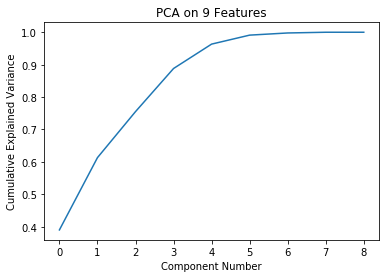

In [29]:
pca.n_components_
f=plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Number')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on 9 Features')
plt.show()
f.savefig('PCA.pdf', bbox_inches='tight')

We only use 5 features as that is all that is needed to represent the data.

In [30]:
pca = PCA(n_components=5)
final = pca.fit_transform(y_norm)
pca.n_components_

5

The training and testing data is transformed to only contain the 5 features.

In [31]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### Generalized Linear Regression Model

The code below fits the training data to a linear regression model by attempting to minimize error. The trained model is then used to predict how much money a movie makes with the testing data.

In [32]:
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)
prediction = linear.predict(X_test)
X_train

array([[-0.53326807,  0.49396164, -0.50861647, -1.1004593 ,  0.03854647],
       [-0.31147425,  1.35848008, -0.21822661,  0.36664927,  0.13722659],
       [-0.84570777, -0.22287137,  0.84596164, -0.3249091 ,  0.09010062],
       ...,
       [-0.79264741, -0.11399966, -0.61166846, -0.87696371,  0.05247523],
       [ 1.8869125 ,  0.54597895, -0.39260267, -0.72120584, -0.28605918],
       [-1.0351417 , -0.47958382, -1.23507511,  0.94144753,  0.09358875]])

The below code shows the percentage of correct predictions as we increase the bounds of the accuracy of the model. When the bounds are around +/- 100,000 dollars, the percentage of correct predictions is approximately 0%. When the bounds are at +/- 100,000,000 dollars, the percentage of correct predictions is approximately 90%.

C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in longlong_scalars
  


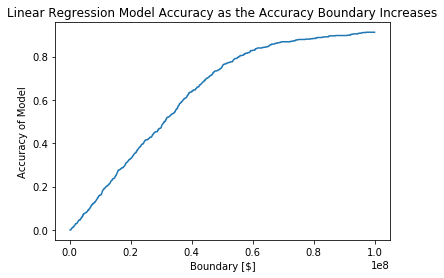

In [33]:
testValues = y_test.as_matrix(columns = None)
lists =[]
numcorrect = []
boundary = []
i = 0
correct = 0
j = 0
for j in range(100000, 100000000, 100000):
    i = 0
    correct = 0
    for i in range(len(prediction)):
        if -j <= (prediction[i] - testValues[i]) and (prediction[i] - testValues[i]) <= j:
            correct += 1
            lists.append(j/testValues[i])
        i += 1
    numcorrect.append(correct/i)
    boundary.append(j)

f=plt.figure()
plt.plot(boundary, numcorrect)
plt.xlabel('Boundary [$]')
plt.ylabel('Accuracy of Model')
plt.title('Linear Regression Model Accuracy as the Accuracy Boundary Increases')
plt.show()
f.savefig('Lin_Reg.pdf', bbox_inches='tight')

#### Decision Tree Regression Model

From the above graph, it can be seen that the linear regression model performs very badly for this data when trying to predict how much money a movie will earn at the box office. Another model will be used to see if an improvement can be made on the results. A decision tree will be used. The depth used will be 20. The deeper the tree, the more complex the decision rules and the fitter the model. In order to verify if it is overfit, the accuracy will be checked using test data (completely separate from the training data).

The model is trained below using a depth of 20 which is plenty in order to represent the data non-linearity.

In [34]:
regr = DecisionTreeRegressor(max_depth=20, random_state=1)
regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

The test data is then applied to the trained model. The test data was not used for the training so the test data will be the first time the model sees them.

In [35]:
mlpprediction = regr.predict(X_test)

Again plot the accuracy of the model as the boundary (predicted money made +/- the accuracy boundary) increases. It shows a better result than the linear regression model. Its seen that with a boundary of +/- $20,000,000, the decision tree model has an accuracy of approximately 50 percent while the linear regression model only has an accuracy of 30 percent. This is a large improvement and overfitting is not present as the test data performs very well.

C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in longlong_scalars
  


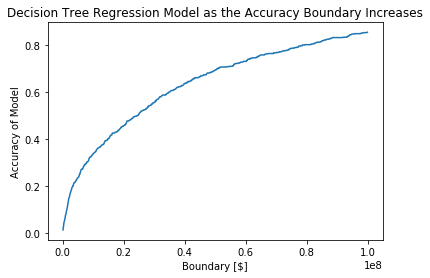

In [36]:
testValues = y_test.as_matrix(columns = None)
lists =[]
numcorrect = []
boundary = []
i = 0
correct = 0
j = 0
for j in range(100000, 100000000, 100000):
    i = 0
    correct = 0
    for i in range(len(mlpprediction)):
        if -j <= mlpprediction[i] - testValues[i] and (mlpprediction[i] - testValues[i]) <= j:
            correct += 1
            lists.append(j/testValues[i])
        i += 1
    numcorrect.append(correct/i)
    boundary.append(j)

f = plt.figure()
plt.plot(boundary, numcorrect)
plt.xlabel('Boundary [$]')
plt.ylabel('Accuracy of Model')
plt.title('Decision Tree Regression Model as the Accuracy Boundary Increases')
plt.show()
f.savefig('Dec_Tree.pdf', bbox_inches='tight')

### Building Classification Model to Predict Oscar Wins

The next criteria of success that will be tracked is whether a movie will win an Oscar. This model will be simpler in that there are a limited number of classes. Since the most Oscars won by by a movie (for acting, directing and best picture win only) is 6. The classes will be split into 6 classes (based on number of Oscar wins).

The dependent variable is chosen to be the total number of Oscar wins in terms of acting, directing and best picture win (as these are seen as the most prestigious awards).

In [37]:
X = df['Total Oscar Wins']
y = df.drop('Name', axis = 1)
y = y.drop('Director', axis=1)
y = y.drop('Star1', axis=1)
y = y.drop('Star2', axis=1)
y = y.drop('Star3', axis=1)
y = y.drop('Star4', axis=1)
y = y.drop('Star5', axis=1)
y = y.drop('Gross', axis=1)
y = y.drop('Inflation adjusted', axis=1)
y = y.drop('starWon', axis=1)
y = y.drop('starNom', axis=1)
y = y.drop('numMovieW', axis=1)
y = y.drop('numMovieN', axis=1)
y = y.drop('numOtherW', axis=1)
y = y.drop('numOtherN', axis=1)
y = y.drop('Total Oscar Wins', axis=1)

The data is split between testing and training (90,10 split)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.1, random_state=1)

Once again the data is normalized/standardize in order to prevent any bias in weightings between features.

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

from sklearn.preprocessing import normalize

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_norm = normalize(y,axis=0)

C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\zach\Anaconda3\envs\engg3130_movieproject\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


A principle component analysis is performed below where the normalized data is used to determine which features are most important

In [40]:
pca = PCA()
final = pca.fit_transform(y_norm)
final.shape

(6610, 9)

The cdf for the PCA analysis can be seen below. It appears as though 95% of the covaraince is represented in only 5 features so the dimension of the data (number of features) will be reduced to 5.

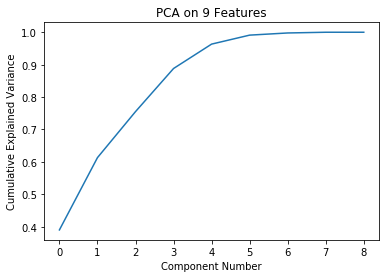

In [41]:
pca.n_components_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Number')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on 9 Features')
plt.show()

In [42]:
pca = PCA(n_components=5)
final = pca.fit_transform(y_norm)
pca.n_components_

5

The training and test data is then transformed to be only the 5 most important features

In [43]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### Naive Bayes Classification Model

The first classification model used is the Naive Bayes model. This model assumesn conditional independence between every pair of features given the value of the class variable. more specifically a Gaussian Naive Bayes model is used.

The code below is used to train the model with the training data. Then the prediction of Oscar wins is found for the test data to see how well the model works. The accuracy is found for the model to determine how well it classifys the data. It seems the classifier is really good at predicting Oscar wins but the confusion matrix will now be plotted.

In [44]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
class_names = ('0 Oscars','1 Oscar','2 Oscars','3 Oscars','4 Oscars','5 Oscars', '6 Oscars','7 Oscars')

Accuracy: 0.8940998487140696


The code below contains a function `plot_confusion_matrix` which takes in the predicted and actual labels for each movie and plots, in a visual way, how accurate each class was predicted  (function taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). The normalized and non-normalized plots can be seen for the Gaussian Naive Bayes model below. The accuracy is really good for predicting 0 Oscar wins but is very poor at predicting any Osars wins above 0. The data is very skewed with many movies that have 0 Oscar wins so the accuracy seen in the previous code block is not actually as good as it looks.

Confusion matrix, without normalization
[[475  26   4   0   0   0]
 [  6  95   6   0   0   0]
 [  0  16  17   0   0   0]
 [  0   0   6   3   1   0]
 [  0   0   0   3   1   1]
 [  0   0   0   0   1   0]]
Normalized confusion matrix
[[0.94 0.05 0.01 0.   0.   0.  ]
 [0.06 0.89 0.06 0.   0.   0.  ]
 [0.   0.48 0.52 0.   0.   0.  ]
 [0.   0.   0.6  0.3  0.1  0.  ]
 [0.   0.   0.   0.6  0.2  0.2 ]
 [0.   0.   0.   0.   1.   0.  ]]


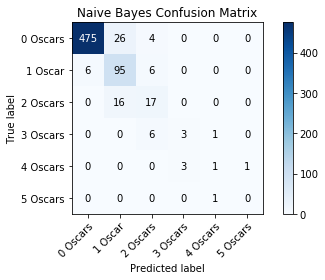

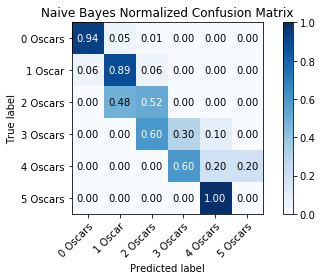

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes, d,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'


    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if d ==1:
        fig.savefig('Bayes_norm.pdf')
    elif d == 0:
        fig.savefig('Bayes.pdf')
    elif d == 2:
        fig.savefig('SVM.pdf')
    elif d == 3:
        fig.savefig('SVM_norm.pdf')
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=0,
                      title='Naive Bayes Confusion Matrix')

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=1, normalize=True,
                      title='Naive Bayes Normalized Confusion Matrix')

#### Support Vector Classification Model
To see if we can improve on the previous results using a Naive Bayes model, a support vector machine is used. This model will be used to see if improvement can be made, specfically in non-linear classification. The kernel `rbf` is used since it is good at predicting non-linear boundaries and from the regression models, it appears as though the features show many non-linear relationships.

The code below creates an SVC model and fits it to the training data.

In [46]:
clf = svm.SVC(gamma=0.001, C=100., random_state=1,verbose=True)
clf.fit(X_train, y_train)

[LibSVM]

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=True)

The model is then tested with the test data to predict Oscar wins. Accuracy of the model is found to determine if there are improvements to the previous Naive Bayes model.

In [47]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


The accuracy is very high so to see how the results are spread, confusion matrices are then plotted.

Confusion matrix, without normalization
[[505   0   0   0   0   0]
 [  0 107   0   0   0   0]
 [  0   0  33   0   0   0]
 [  0   0   0  10   0   0]
 [  0   0   0   0   5   0]
 [  0   0   0   0   0   1]]
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


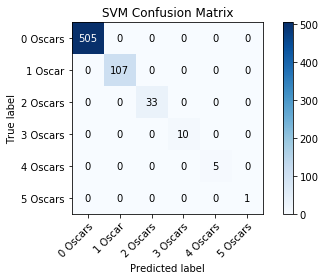

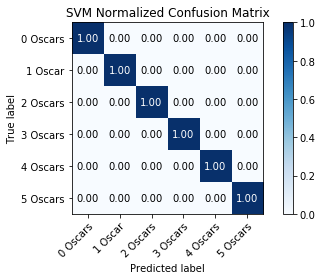

In [48]:
np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=2,
                      title='SVM Confusion Matrix')

plot_confusion_matrix(y_test, y_pred, classes=class_names, d=3, normalize=True,
                      title='SVM Normalized Confusion Matrix')

As seen above, the results are really good. The SVM model is actually able to classify Oscar wins with great accuracy. And the test data is not even the same as the training data so this validates the model very well.

Just for fun, 5 features from the predicted number of Oscar wins are plotted to see how the data is spread and if we can acually see any distinct relationships visually. The dimensions are as listed below:

- X-axis = Metascore Rating
- Y-axis = IMDb Rating
- Z-axis = Runtime
- Circle Size = Genre
- Colour = Predicted Oscar win
    - blue = 1 Oscar
    - yellow = 2 Oscars
    - green = 3 Oscars
    - purple = 4 Oscars
    - brown = 5 Oscars
    - black = 6 Oscars

It can be seen that it is very difficult to distinguish classes visually, even at this angle but the SVM model was able to discern between the classes non-linearly.

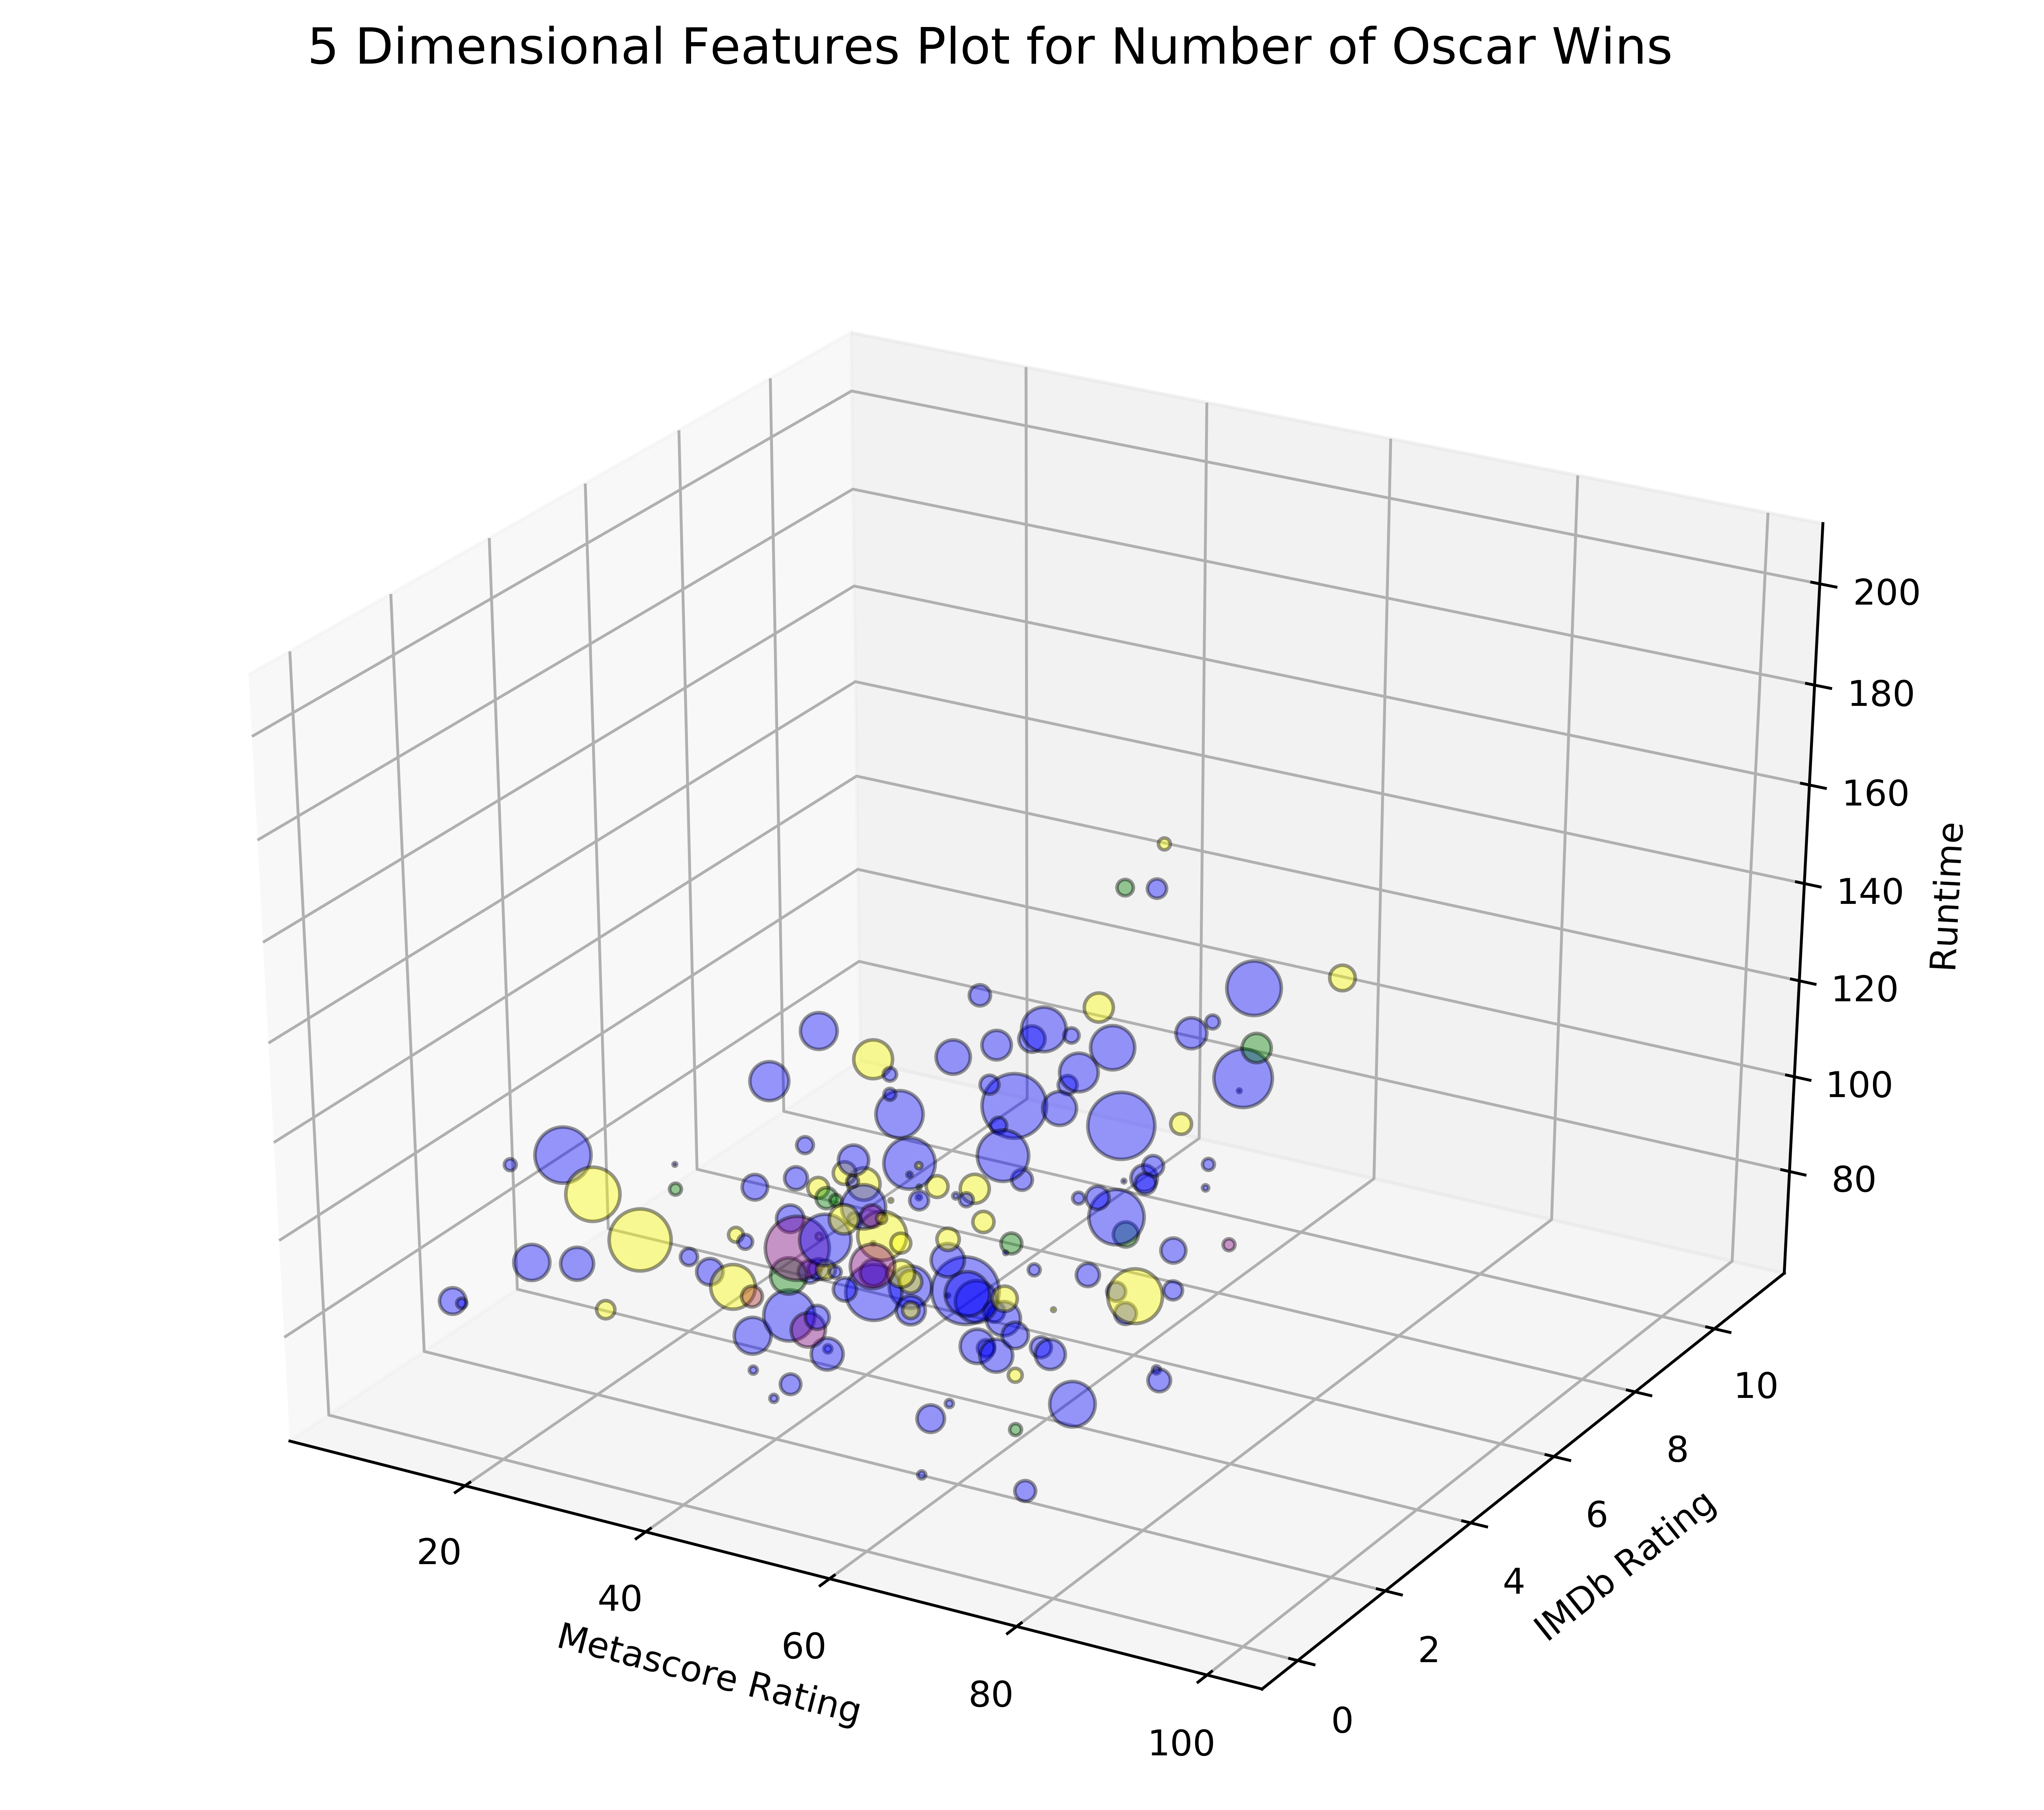

In [49]:
fig1 = plt.figure(figsize=(10, 8), dpi=800)
ax = fig1.gca(projection='3d')

t = fig1.suptitle('5 Dimensional Features Plot for Number of Oscar Wins', fontsize=14)

data_points=[]
for j in y_test.index:
    xs=y.iloc[j,4]
    ys=y.iloc[j,3]
    zs=y.iloc[j,2]
    ss=y.iloc[j,1]
    data_points.append([xs,ys,zs,ss])



colours=[]
for i,wt in enumerate(list(y_pred)):
    if wt == 0:
        colours.append(1)
    elif wt == 1:
        colours.append('blue')
    elif wt == 2:
        colours.append('yellow')
    elif wt == 3:
        colours.append('green')
    elif wt == 4:
        colours.append('purple')
    elif wt == 5:
        colours.append('brown')
    elif wt == 5:
        colours.append('black')

for i,j in enumerate(data_points):
    x = j[0]
    w = j[1]
    z = j[2]
    s = j[3]
    c = colours[i]
    if c == 1:
        ax.scatter(x, w, z, alpha=0, edgecolors='none', s=s)
    else:
        ax.scatter(x, w, z, alpha=0.4, c=c, edgecolors='none', s=s)

ax.set_xlabel('Metascore Rating')
ax.set_ylabel('IMDb Rating')
ax.set_zlabel('Runtime')
plt.show()
fig1.savefig('features_class.pdf', bbox_inches='tight')

### Conclusion

It was found that decision trees are very good in predicting how much money a movie will make. It does this due to the non-linearity in the spread of data. This non-linear relationship in the data means that a model such as a generalized linear regression model would produce poor results (which was seen previously).

From these results classification models were then used to predict the number of Oscar wins. A simple Gaussian Naive Bayes model was used first because it is fast to train (only compare each data point features to the average of the class features) even though it is generally not a very good estimator (it assumes independent features which almost never occurs in real life). The accuracy was found to be high but the data is very skewed to 0 Oscar wins. So the accuracy is not as high as it appears for predicting movies that did win Oscars. An SVM model was then used due to the large non-linearities in the data. From the SVM model, it was seen that the accuracy was even better than the Naive Bayes model and it was able to correctly predict most of the movies that had actually won Oscars. In the end, 2 good models were created that could accurately predict a movies success (movie box office and Oscar wins).